# Kohonen

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import os
from matplotlib.colors import ListedColormap
from tqdm import tqdm
import matplotlib.patches as patches
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans

class KohonenNetwork:
    def __init__(self, input_dim, grid_size=(10, 10), neighborhood_function='gaussian', 
                 neighborhood_width=1.0, learning_rate_decay=1000, topology='rectangular'):
        self.input_dim = input_dim
        self.grid_size = grid_size
        self.M, self.N = grid_size
        self.topology = topology
        
        if topology == 'rectangular':
            self.weights = np.random.rand(self.M, self.N, input_dim)
        elif topology == 'hexagonal':
            self.weights = np.random.rand(self.M, self.N, input_dim)
        else:
            raise ValueError("Topologia musi być 'rectangular' lub 'hexagonal'")
        
        if neighborhood_function == 'gaussian':
            self.neighborhood_function = self._gaussian
        elif neighborhood_function == 'mexican_hat':
            self.neighborhood_function = self._mexican_hat
        else:
            raise ValueError("Funkcja sąsiedztwa musi być 'gaussian' lub 'mexican_hat'")
        
        self.neighborhood_width = neighborhood_width
        self.learning_rate_decay = learning_rate_decay
        
        self._initialize_neuron_positions()
    
    def _initialize_neuron_positions(self):
        if self.topology == 'rectangular':
            self.neuron_positions = np.array([[(i, j) for j in range(self.N)] for i in range(self.M)]) # siatka prostokątna
        elif self.topology == 'hexagonal':
            self.neuron_positions = np.zeros((self.M, self.N, 2))
            for i in range(self.M):
                for j in range(self.N):
                    if i % 2 == 0:
                        self.neuron_positions[i, j] = [i * np.sqrt(3)/2, j]
                    else:
                        self.neuron_positions[i, j] = [i * np.sqrt(3)/2, j + 0.5]
    
    def _gaussian(self, distance, t):
        sigma0 = self.neighborhood_width
        tau    = self.learning_rate_decay
        sigma = sigma0 * np.exp(-t / tau)
        return np.exp(-(distance ** 2) / (2 * sigma ** 2))


    def _mexican_hat(self, distance, t):
        sigma0 = self.neighborhood_width
        tau    = self.learning_rate_decay
        sigma  = sigma0 * np.exp(-t / tau)
        dist2 = distance ** 2
        factor = dist2 / (sigma ** 2)
        return (1 - factor) * np.exp(-dist2 / (2 * sigma ** 2))

    
    def _learning_rate(self, t):
        return np.exp(-t / self.learning_rate_decay)
    
    def _calculate_distances(self, bmu):
        if self.topology == 'rectangular':
            grid_dist = np.sum((self.neuron_positions - np.array(bmu)) ** 2, axis=2) ** 0.5
        elif self.topology == 'hexagonal':
            bmu_pos = self.neuron_positions[bmu[0], bmu[1]]
            distances = np.zeros((self.M, self.N))
            for i in range(self.M):
                for j in range(self.N):
                    distances[i, j] = np.linalg.norm(self.neuron_positions[i, j] - bmu_pos)
            grid_dist = distances
        return grid_dist
    
    def _find_bmu(self, x):
        distances = np.sum((self.weights - x) ** 2, axis=2)
        bmu_idx = np.unravel_index(np.argmin(distances), distances.shape)
        return bmu_idx
    
    def train(self, data, epochs=100, verbose=True):
        n_samples = data.shape[0]
        for epoch in tqdm(range(epochs), desc="Trening sieci", unit="epoka"):
            indices = np.random.permutation(n_samples)
            for idx in indices:
                x = data[idx]
                bmu = self._find_bmu(x)
                grid_dist = self._calculate_distances(bmu)
                learning_rate = self._learning_rate(epoch)
                neighborhood = self.neighborhood_function(grid_dist, epoch)
                update = learning_rate * neighborhood[:, :, np.newaxis] * (x - self.weights)
                self.weights += update
    
    def map_input(self, x):
        return self._find_bmu(x)
    
    def get_mapped_data(self, data):
        return np.array([self.map_input(x) for x in data])

    def get_cluster_labels(self, data):
        bmu_indices = self.get_mapped_data(data)
        cluster_labels = np.array([i * self.N + j for i, j in bmu_indices])
        return cluster_labels
    
    def calculate_silhouette_score(self, data, cluster_labels=None):
        if cluster_labels is None:
            cluster_labels = self.get_cluster_labels(data)
            
        unique_clusters = np.unique(cluster_labels)
        
        if len(unique_clusters) < 2:
            return {
                'silhouette_score': None,
                'silhouette_samples': None,
                'error': 'Need at least 2 clusters for silhouette score calculation'
            }
        try:
            sil_score = silhouette_score(data, cluster_labels)
            sil_samples = silhouette_samples(data, cluster_labels)
            
            return {
                'silhouette_score': sil_score,
                'silhouette_samples': sil_samples,
                'error': None
            }
        except Exception as e:
            return {
                'silhouette_score': None,
                'silhouette_samples': None,
                'error': str(e)
            }
    
    def visualize_silhouette(self, data, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 8))
        cluster_labels = self.get_cluster_labels(data)
        silhouette_result = self.calculate_silhouette_score(data, cluster_labels)
        
        if silhouette_result['error'] is not None:
            ax.text(0.5, 0.5, f"Error: {silhouette_result['error']}", 
                    ha='center', va='center', transform=ax.transAxes)
            return ax
            
        sil_samples = silhouette_result['silhouette_samples']
        unique_clusters = np.unique(cluster_labels)
        n_clusters = len(unique_clusters)
        y_lower = 10
        cmap = plt.cm.get_cmap('viridis', n_clusters)
        
        for i, cluster in enumerate(unique_clusters):
            ith_cluster_sil_values = sil_samples[cluster_labels == cluster]
            ith_cluster_sil_values.sort()
            cluster_size = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + cluster_size
            color = cmap(i / n_clusters)
            ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values,
                             facecolor=color, edgecolor=color, alpha=0.7)
            ax.text(-0.05, y_lower + 0.5 * cluster_size, str(cluster))
            y_lower = y_upper + 10
        ax.axvline(x=silhouette_result['silhouette_score'], color="red", linestyle="--")
        
        ax.set_title(f"Silhouette Plot (Score: {silhouette_result['silhouette_score']:.3f})")
        ax.set_xlabel("Silhouette Coefficient Values")
        ax.set_ylabel("Cluster Label")
        ax.set_yticks([])
        ax.set_xlim([-0.1, 1])
        
        return ax
    
    def visualize_map(self, data=None, labels=None, title="Siec Kohonena", ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 8))
        if self.topology == 'hexagonal':
            self._visualize_hexagonal_map(data, labels, title, ax)
        else:
            self._visualize_rectangular_map(data, labels, title, ax)
        return ax
    
    def _visualize_rectangular_map(self, data, labels, title, ax):
        if data is not None and labels is not None:
            mapped_data = self.get_mapped_data(data)
            unique_labels = np.unique(labels)
            grid_labels = np.zeros((self.M, self.N))
            grid_counts = np.zeros((self.M, self.N))
            
            for data_idx, (i, j) in enumerate(mapped_data):
                label = labels[data_idx]
                grid_labels[i, j] += label
                grid_counts[i, j] += 1
            
            neuron_classes = np.zeros((self.M, self.N))
            for i in range(self.M):
                for j in range(self.N):
                    if grid_counts[i, j] > 0:
                        neuron_classes[i, j] = grid_labels[i, j] / grid_counts[i, j]
                    else:
                        neuron_classes[i, j] = -1
            
            cmap = plt.cm.get_cmap('viridis', len(unique_labels))
            masked_data = np.ma.masked_where(grid_counts == 0, neuron_classes)
            im = ax.imshow(masked_data, cmap=cmap, interpolation='nearest', 
                          vmin=np.min(unique_labels), vmax=np.max(unique_labels))
            
            for i in range(self.M):
                for j in range(self.N):
                    if grid_counts[i, j] > 0:
                        ax.text(j, i, str(int(grid_counts[i, j])), 
                               ha="center", va="center", color="white", fontsize=8)
            
            cbar = plt.colorbar(im, ax=ax)
            cbar.set_label("Dominująca klasa")
            
            for i in range(self.M + 1):
                ax.axhline(i - 0.5, color='k', linestyle='-', alpha=0.3)
            for j in range(self.N + 1):
                ax.axvline(j - 0.5, color='k', linestyle='-', alpha=0.3)
        else:
            for i in range(self.M):
                for j in range(self.N):
                    ax.plot(j, i, 'ko', markersize=8)
            
            for i in range(self.M):
                for j in range(self.N):
                    if i < self.M - 1:
                        ax.plot([j, j], [i, i+1], 'k-', alpha=0.3)
                    if j < self.N - 1:
                        ax.plot([j, j+1], [i, i], 'k-', alpha=0.3)
        
        ax.set_title(title)
        ax.set_xlim(-0.5, self.N - 0.5)
        ax.set_ylim(self.M - 0.5, -0.5)
        ax.set_aspect('equal')
        
        ax.set_xlabel("Kolumna neuronu")
        ax.set_ylabel("Wiersz neuronu")
    
    def _visualize_hexagonal_map(self, data, labels, title, ax):
        neuron_info = {}
        if data is not None and labels is not None:
            if not isinstance(labels, np.ndarray):
                labels = np.array(labels)
            mapped_data = self.get_mapped_data(data)
            unique_labels = np.unique(labels)
            
            for i in range(self.M):
                for j in range(self.N):
                    neuron_info[(i, j)] = {'counts': {label: 0 for label in unique_labels}, 
                                        'total': 0, 
                                        'dominant_class': None,
                                        'purity': 0.0}
            
            for data_idx, (i, j) in enumerate(mapped_data):
                label = labels[data_idx]
                neuron_info[(i, j)]['counts'][label] += 1
                neuron_info[(i, j)]['total'] += 1
            
            for pos, info in neuron_info.items():
                if info['total'] > 0:
                    dominant_class = max(info['counts'].items(), key=lambda x: x[1])[0]
                    info['dominant_class'] = dominant_class
                    info['purity'] = info['counts'][dominant_class] / info['total']
            
            cmap = plt.cm.get_cmap('viridis', len(unique_labels))
        
        hex_size = 0.4
        angles = np.linspace(0, 2*np.pi, 7)
        
        for i in range(self.M):
            for j in range(self.N):
                center = self.neuron_positions[i, j]
                
                hex_x = center[1] + hex_size * np.cos(angles)
                hex_y = center[0] + hex_size * np.sin(angles)
                hex_vertices = list(zip(hex_x, hex_y))
                
                if data is not None and labels is not None:
                    info = neuron_info[(i, j)]
                    
                    if info['total'] > 0:
                        color_idx = info['dominant_class'] / max(unique_labels)
                        color = cmap(color_idx)
                        
                        alpha = max(0.3, info['purity'])
                        
                        hex_patch = patches.Polygon(hex_vertices, 
                                                facecolor=color, 
                                                edgecolor='black', 
                                                alpha=alpha,
                                                linewidth=1)
                        
                        ax.text(center[1], center[0], str(info['total']), 
                            ha="center", va="center", 
                            color="white", fontsize=8, fontweight='bold')
                    else:
                        hex_patch = patches.Polygon(hex_vertices, 
                                                facecolor='white', 
                                                edgecolor='black', 
                                                alpha=0.3,
                                                linewidth=0.5)
                else:
                    hex_patch = patches.Polygon(hex_vertices, 
                                            facecolor='white', 
                                            edgecolor='black', 
                                            alpha=0.7,
                                            linewidth=0.5)
                ax.add_patch(hex_patch)
        if data is not None and labels is not None:
            sm = plt.cm.ScalarMappable(cmap=cmap, 
                                    norm=plt.Normalize(vmin=min(unique_labels), 
                                                        vmax=max(unique_labels)))
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=ax)
            cbar.set_label("Dominująca klasa")
        
        ax.set_title(title)
        ax.set_aspect('equal')
        ax.set_xlim(np.min(self.neuron_positions[:, :, 1]) - hex_size - 0.5, 
                np.max(self.neuron_positions[:, :, 1]) + hex_size + 0.5)
        ax.set_ylim(np.min(self.neuron_positions[:, :, 0]) - hex_size - 0.5, 
                np.max(self.neuron_positions[:, :, 0]) + hex_size + 0.5)
        ax.axis('off')
    
    def analyze_clustering(self, data, labels):
        mapped_data = self.get_mapped_data(data)
        unique_labels = np.unique(labels)
        neuron_class_counts = {}
        
        for i in range(self.M):
            for j in range(self.N):
                neuron_class_counts[(i, j)] = {label: 0 for label in unique_labels}
        
        for data_idx, (i, j) in enumerate(mapped_data):
            label = labels[data_idx]
            neuron_class_counts[(i, j)][label] += 1
        
        neurons_with_mixed_classes = 0
        neurons_with_data = 0
        
        for (i, j), class_counts in neuron_class_counts.items():
            if sum(class_counts.values()) > 0:
                neurons_with_data += 1
                classes_in_neuron = sum(1 for count in class_counts.values() if count > 0)
                if classes_in_neuron > 1:
                    neurons_with_mixed_classes += 1
        
        neuron_coords = []
        for (i, j), class_counts in neuron_class_counts.items():
            if sum(class_counts.values()) > 0:
                neuron_coords.append((i, j))
        
        if not neuron_coords:
            clusters = []
        else:
            neuron_coords = np.array(neuron_coords)
            visited = set()
            clusters = []
            
            for idx, (i, j) in enumerate(neuron_coords):
                if (i, j) in visited:
                    continue
                
                cluster = [(i, j)]
                visited.add((i, j))
                
                stack = [(i, j)]
                while stack:
                    x, y = stack.pop()
                    neighbors = self._get_neighbors(x, y)
                    
                    for nx, ny in neighbors:
                        if (nx, ny) in neuron_class_counts and (nx, ny) not in visited:
                            if sum(neuron_class_counts[(nx, ny)].values()) > 0:
                                cluster.append((nx, ny))
                                visited.add((nx, ny))
                                stack.append((nx, ny))
                
                clusters.append(cluster)
        
        clusters_match_classes = len(clusters) == len(unique_labels)
        
        class_positions = {label: np.zeros(2) for label in unique_labels}
        class_counts = {label: 0 for label in unique_labels}
        
        for data_idx, (i, j) in enumerate(mapped_data):
            label = labels[data_idx]
            if self.topology == 'hexagonal':
                class_positions[label] += self.neuron_positions[i, j]
            else:
                class_positions[label] += np.array([i, j])
            class_counts[label] += 1
        
        for label in unique_labels:
            if class_counts[label] > 0:
                class_positions[label] /= class_counts[label]
        
        neuron_stats = {}
        for (i, j), class_counts in neuron_class_counts.items():
            total = sum(class_counts.values())
            if total > 0:
                dominant_class = max(class_counts.items(), key=lambda x: x[1])[0]
                purity = class_counts[dominant_class] / total
                neuron_stats[(i, j)] = {
                    'total_samples': total,
                    'class_counts': class_counts,
                    'dominant_class': dominant_class,
                    'purity': purity
                }
        
        silhouette_results = self.calculate_silhouette_score(data)
        
        return {
            'num_clusters': len(clusters),
            'num_classes': len(unique_labels),
            'clusters_match_classes': clusters_match_classes,
            'neurons_with_mixed_classes': neurons_with_mixed_classes,
            'neurons_with_data': neurons_with_data,
            'mixed_classes_percentage': neurons_with_mixed_classes / neurons_with_data if neurons_with_data > 0 else 0,
            'class_positions': class_positions,
            'neuron_stats': neuron_stats,
            'clusters': clusters,
            'silhouette_score': silhouette_results.get('silhouette_score', None),
            'silhouette_error': silhouette_results.get('error', None)
        }
    
    def _get_neighbors(self, i, j):
        """Znajdź sąsiadów neuronu w zależności od topologii"""
        if self.topology == 'rectangular':
            return [(i+1, j), (i-1, j), (i, j+1), (i, j-1)]
        elif self.topology == 'hexagonal':
            if i % 2 == 0:  # Parzyste wiersze
                neighbors = [
                    (i-1, j-1), (i-1, j),   # Górzy sąsiedzi
                    (i, j-1), (i, j+1),     # Boczni sąsiedzi
                    (i+1, j-1), (i+1, j)    # Dolni sąsiedzi
                ]
            else:  # Nieparzyste wiersze
                neighbors = [
                    (i-1, j), (i-1, j+1),   # Górzy sąsiedzi
                    (i, j-1), (i, j+1),     # Boczni sąsiedzi
                    (i+1, j), (i+1, j+1)    # Dolni sąsiedzi
                ]
            
            # Filtruj sąsiadów, aby pozostali w granicach siatki
            valid_neighbors = []
            for ni, nj in neighbors:
                if 0 <= ni < self.M and 0 <= nj < self.N:
                    valid_neighbors.append((ni, nj))
            return valid_neighbors
    
    def visualize_weight_planes(self, ax=None):
        if ax is None:
            nrows = int(np.ceil(self.input_dim / 2))
            fig, axes = plt.subplots(nrows, 2, figsize=(12, 3 * nrows))
            axes = axes.flatten()
        else:
            nrows = int(np.ceil(self.input_dim / 2))
            ncols = 2
            if self.input_dim == 1:
                axes = [ax]
            else:
                axes = np.array(ax).flatten()
        
        for i in range(self.input_dim):
            if i < len(axes):
                weight_plane = self.weights[:, :, i]
                im = axes[i].imshow(weight_plane, cmap='viridis', interpolation='nearest')
                axes[i].set_title(f"Wymiar {i+1}")
                plt.colorbar(im, ax=axes[i])
                
                for row in range(self.M + 1):
                    axes[i].axhline(row - 0.5, color='k', linestyle='-', alpha=0.3)
                for col in range(self.N + 1):
                    axes[i].axvline(col - 0.5, color='k', linestyle='-', alpha=0.3)
        
        if ax is None:
            for i in range(self.input_dim, len(axes)):
                axes[i].axis('off')
            
            plt.tight_layout()
        return axes

# Data

## Loaders

### KOH 1

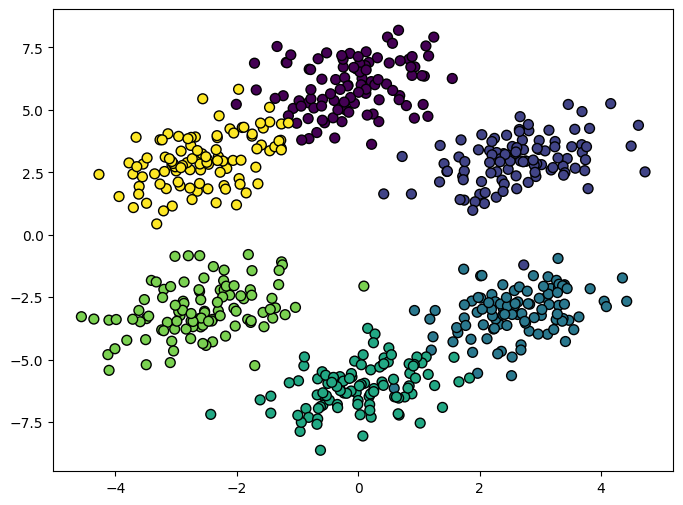

In [5]:
hexagon_path = "data/hexagon.csv"
data = pd.read_csv(hexagon_path, header=1).values
classes = data[:, 2]
data = data[:, :2]
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c=classes, cmap='viridis', edgecolor='k', s=50)

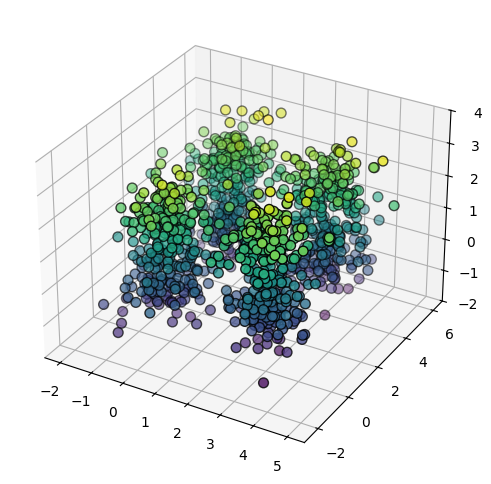

In [3]:
cube_path = "data/cube.csv"
data = pd.read_csv(cube_path, header=1).values
classes = data[:, 2]
data = data[:, :3]
plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=classes, cmap='viridis', edgecolor='k', s=50)

#### Helper function

In [35]:
def analyze_som_clustering(data, labels=None, max_clusters=10, grid_size=(4, 4), epochs = 100, neighborhood_function='gaussian', topology = 'rectangular', neighbor_width=1.0):
    print(f"Training SOM with fixed grid size {grid_size[0]}x{grid_size[1]}...")
    som = KohonenNetwork(input_dim=data.shape[1], grid_size=grid_size,
                       topology=topology, neighborhood_function=neighborhood_function, neighborhood_width=neighbor_width)
    som.train(data, epochs=epochs)
    
    mapped_data = som.get_mapped_data(data)
    som_labels = np.array([i * grid_size[1] + j for i, j in mapped_data])
    silhouette_scores = []
    cluster_sizes = range(2, max_clusters+1)
    
    for n_clusters in cluster_sizes:
        print(f"Evaluating with {n_clusters} clusters...")
        unique_neurons = np.unique(mapped_data, axis=0)
        neuron_weights = np.array([som.weights[i, j] for i, j in unique_neurons])
        
        if len(unique_neurons) < n_clusters:
            print(f"  Warning: Only {len(unique_neurons)} unique neurons activated, can't create {n_clusters} clusters")
            silhouette_scores.append(float('nan'))
            continue
            
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        neuron_clusters = kmeans.fit_predict(neuron_weights)
        
        data_clusters = np.zeros(len(data), dtype=int)
        for idx, (i, j) in enumerate(mapped_data):
            neuron_idx = np.where((unique_neurons == [i, j]).all(axis=1))[0][0]
            data_clusters[idx] = neuron_clusters[neuron_idx]
        
        try:
            score = silhouette_score(data, data_clusters)
            silhouette_scores.append(float(score))
            print(f"  Silhouette score: {score:.3f}")
        except Exception as e:
            print(f"  Error calculating silhouette score: {e}")
            silhouette_scores.append(float('nan'))
    
    return cluster_sizes, silhouette_scores

Training SOM with fixed grid size 10x10...


Trening sieci: 100%|██████████| 100/100 [00:02<00:00, 39.34epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.576
Evaluating with 3 clusters...
  Silhouette score: 0.477
Evaluating with 4 clusters...
  Silhouette score: 0.449
Evaluating with 5 clusters...
  Silhouette score: 0.519
Evaluating with 6 clusters...
  Silhouette score: 0.595
Evaluating with 7 clusters...
  Silhouette score: 0.523
Evaluating with 8 clusters...
  Silhouette score: 0.454
Evaluating with 9 clusters...
  Silhouette score: 0.408
Evaluating with 10 clusters...
  Silhouette score: 0.392
Evaluating with 11 clusters...
  Silhouette score: 0.374
Evaluating with 12 clusters...
  Silhouette score: 0.359
Evaluating with 13 clusters...
  Silhouette score: 0.320
Evaluating with 14 clusters...
  Silhouette score: 0.297
Evaluating with 15 clusters...
  Silhouette score: 0.291
Optimal number of clusters: 6 with silhouette score: 0.595


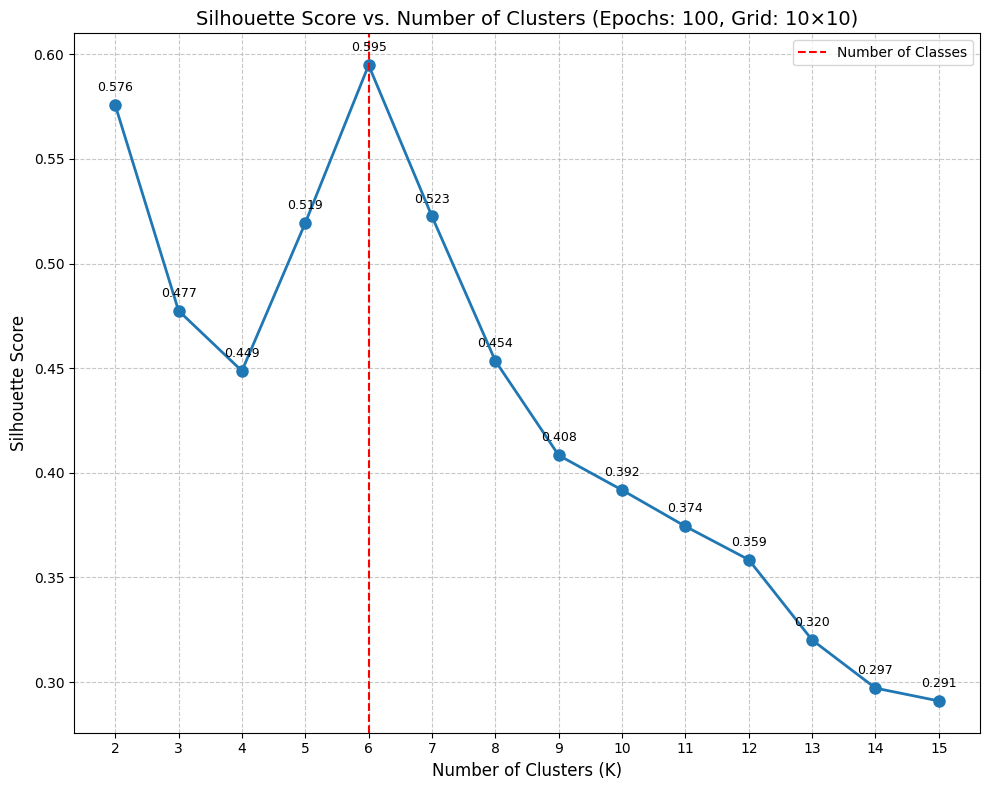

In [40]:
data = pd.read_csv(hexagon_path, header=1).values
classes = data[:, 2]
data = data[:, :2]

unique_classes = len(np.unique(classes))

grid_size = (10, 10)
epoch_size = 100
plt.figure(figsize=(10, 8))
plt.title("Cluster Number Analysis", fontsize=16)
cluster_sizes, silhouette_scores = analyze_som_clustering(
    data,
    max_clusters=15,
    grid_size=grid_size,
    epochs=epoch_size
)

plt.plot(cluster_sizes, silhouette_scores, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title(f'Silhouette Score vs. Number of Clusters (Epochs: {epoch_size}, Grid: {grid_size[0]}×{grid_size[1]})', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(cluster_sizes)

for i, score in enumerate(silhouette_scores):
    if not np.isnan(score):
        plt.annotate(f'{score:.3f}',
                (cluster_sizes[i], score),
                textcoords="offset points",
                xytext=(0, 10),
                ha='center',
                fontsize=9)
plt.axvline(x=unique_classes, color='r', linestyle='--', label='Number of Classes')
plt.legend()

valid_scores = [(k, score) for k, score in zip(cluster_sizes, silhouette_scores) if not np.isnan(score)]
if valid_scores:
    best_k, best_score = max(valid_scores, key=lambda x: x[1])
    print(f"Optimal number of clusters: {best_k} with silhouette score: {best_score:.3f}")
else:
    print("No valid silhouette scores found")

plt.tight_layout()
plt.show()

Training SOM with fixed grid size 10x10...


Trening sieci: 100%|██████████| 100/100 [00:05<00:00, 19.79epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.444
Evaluating with 3 clusters...
  Silhouette score: 0.421
Evaluating with 4 clusters...
  Silhouette score: 0.461
Evaluating with 5 clusters...
  Silhouette score: 0.429
Evaluating with 6 clusters...
  Silhouette score: 0.399
Evaluating with 7 clusters...
  Silhouette score: 0.400
Evaluating with 8 clusters...
  Silhouette score: 0.332
Evaluating with 9 clusters...
  Silhouette score: 0.361
Evaluating with 10 clusters...
  Silhouette score: 0.312
Evaluating with 11 clusters...
  Silhouette score: 0.303
Evaluating with 12 clusters...
  Silhouette score: 0.317
Evaluating with 13 clusters...
  Silhouette score: 0.284
Evaluating with 14 clusters...
  Silhouette score: 0.271
Evaluating with 15 clusters...
  Silhouette score: 0.234
Optimal number of clusters: 4 with silhouette score: 0.461

Data shape: (1199, 3)
Number of unique classes: 8
Sample classes: [0. 1. 2. 3. 4. 5. 6. 7.]


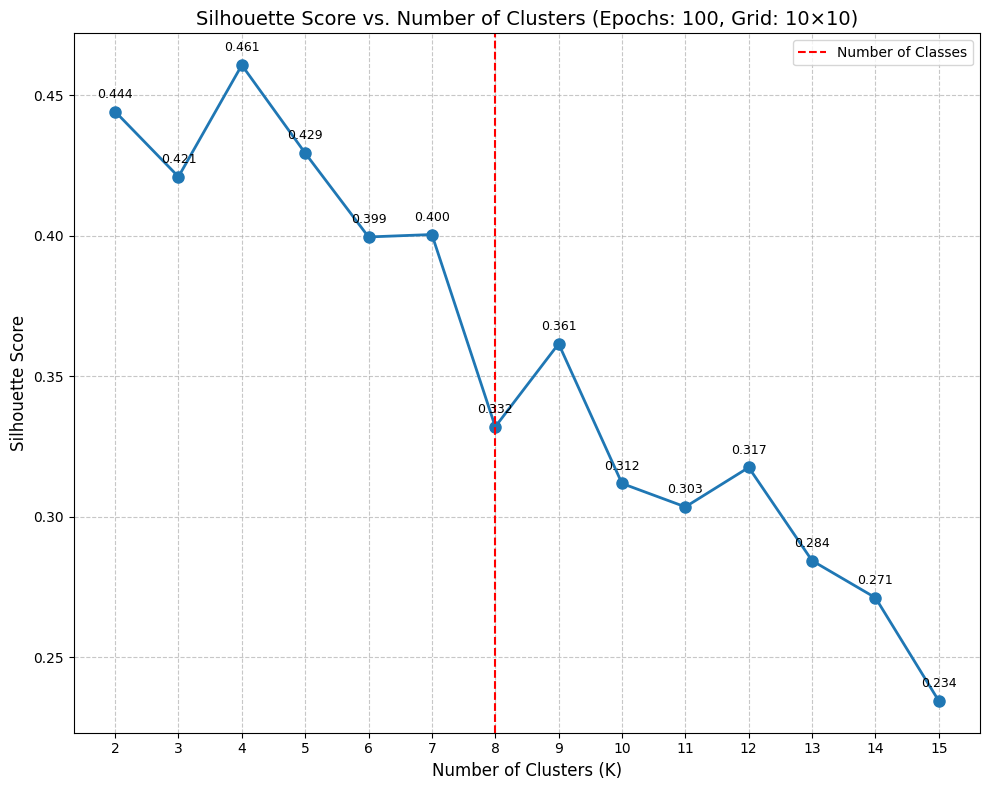

In [41]:
cube_path = "data/cube.csv"
data = pd.read_csv(cube_path, header=1).values
classes = data[:, 3]  # Classes are in the 4th column (index 3)
data = data[:, :3]     # Take first 3 columns (x, y, z coordinates)

# Count unique classes
unique_classes = len(np.unique(classes))

# Define parameters
grid_size = (10, 10)  # You may want to adjust this for 3D data
epoch_size = 100

# Create a single plot
plt.figure(figsize=(10, 8))
plt.title("Cluster Number Analysis - Cube Dataset", fontsize=16)

# Analyze SOM clustering
cluster_sizes, silhouette_scores = analyze_som_clustering(
    data,
    max_clusters=15,
    grid_size=grid_size,
    epochs=epoch_size
)

# Plot the results
plt.plot(cluster_sizes, silhouette_scores, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title(f'Silhouette Score vs. Number of Clusters (Epochs: {epoch_size}, Grid: {grid_size[0]}×{grid_size[1]})', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(cluster_sizes)

# Add annotations for silhouette scores
for i, score in enumerate(silhouette_scores):
    if not np.isnan(score):
        plt.annotate(f'{score:.3f}',
                (cluster_sizes[i], score),
                textcoords="offset points",
                xytext=(0, 10),
                ha='center',
                fontsize=9)

# Add vertical line for number of classes
plt.axvline(x=unique_classes, color='r', linestyle='--', label='Number of Classes')
plt.legend()

# Find and print optimal clusters
valid_scores = [(k, score) for k, score in zip(cluster_sizes, silhouette_scores) if not np.isnan(score)]
if valid_scores:
    best_k, best_score = max(valid_scores, key=lambda x: x[1])
    print(f"Optimal number of clusters: {best_k} with silhouette score: {best_score:.3f}")
else:
    print("No valid silhouette scores found")

# Print some data info
print(f"\nData shape: {data.shape}")
print(f"Number of unique classes: {unique_classes}")
print(f"Sample classes: {np.unique(classes)}")

plt.tight_layout()
plt.show()

### Tests

#### Number of epochs

Training SOM with fixed grid size 10x10...


Trening sieci: 100%|██████████| 10/10 [00:02<00:00,  4.21epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.575
Evaluating with 3 clusters...
  Silhouette score: 0.504
Evaluating with 4 clusters...
  Silhouette score: 0.486
Evaluating with 5 clusters...
  Silhouette score: 0.546
Evaluating with 6 clusters...
  Silhouette score: 0.581
Evaluating with 7 clusters...
  Silhouette score: 0.557
Evaluating with 8 clusters...
  Silhouette score: 0.519
Evaluating with 9 clusters...
  Silhouette score: 0.479
Evaluating with 10 clusters...
  Silhouette score: 0.430
Evaluating with 11 clusters...
  Silhouette score: 0.381
Evaluating with 12 clusters...
  Silhouette score: 0.350
Evaluating with 13 clusters...
  Silhouette score: 0.347
Evaluating with 14 clusters...
  Silhouette score: 0.344
Evaluating with 15 clusters...
  Silhouette score: 0.341
Epochs 10: Optimal clusters = 6, Silhouette score = 0.581
Training SOM with fixed grid size 10x10...


Trening sieci: 100%|██████████| 20/20 [00:04<00:00,  4.14epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.576
Evaluating with 3 clusters...
  Silhouette score: 0.467
Evaluating with 4 clusters...
  Silhouette score: 0.458
Evaluating with 5 clusters...
  Silhouette score: 0.528
Evaluating with 6 clusters...
  Silhouette score: 0.482
Evaluating with 7 clusters...
  Silhouette score: 0.543
Evaluating with 8 clusters...
  Silhouette score: 0.442
Evaluating with 9 clusters...
  Silhouette score: 0.439
Evaluating with 10 clusters...
  Silhouette score: 0.397
Evaluating with 11 clusters...
  Silhouette score: 0.383
Evaluating with 12 clusters...
  Silhouette score: 0.367
Evaluating with 13 clusters...
  Silhouette score: 0.362
Evaluating with 14 clusters...
  Silhouette score: 0.338
Evaluating with 15 clusters...
  Silhouette score: 0.302
Epochs 20: Optimal clusters = 2, Silhouette score = 0.576
Training SOM with fixed grid size 10x10...


Trening sieci: 100%|██████████| 50/50 [00:12<00:00,  4.09epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.576
Evaluating with 3 clusters...
  Silhouette score: 0.501
Evaluating with 4 clusters...
  Silhouette score: 0.459
Evaluating with 5 clusters...
  Silhouette score: 0.501
Evaluating with 6 clusters...
  Silhouette score: 0.596
Evaluating with 7 clusters...
  Silhouette score: 0.516
Evaluating with 8 clusters...
  Silhouette score: 0.454
Evaluating with 9 clusters...
  Silhouette score: 0.382
Evaluating with 10 clusters...
  Silhouette score: 0.350
Evaluating with 11 clusters...
  Silhouette score: 0.312
Evaluating with 12 clusters...
  Silhouette score: 0.311
Evaluating with 13 clusters...
  Silhouette score: 0.282
Evaluating with 14 clusters...
  Silhouette score: 0.280
Evaluating with 15 clusters...
  Silhouette score: 0.262
Epochs 50: Optimal clusters = 6, Silhouette score = 0.596
Training SOM with fixed grid size 10x10...


Trening sieci: 100%|██████████| 100/100 [00:24<00:00,  4.11epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.576
Evaluating with 3 clusters...
  Silhouette score: 0.475
Evaluating with 4 clusters...
  Silhouette score: 0.485
Evaluating with 5 clusters...
  Silhouette score: 0.466
Evaluating with 6 clusters...
  Silhouette score: 0.572
Evaluating with 7 clusters...
  Silhouette score: 0.520
Evaluating with 8 clusters...
  Silhouette score: 0.518
Evaluating with 9 clusters...
  Silhouette score: 0.475
Evaluating with 10 clusters...
  Silhouette score: 0.429
Evaluating with 11 clusters...
  Silhouette score: 0.370
Evaluating with 12 clusters...
  Silhouette score: 0.328
Evaluating with 13 clusters...
  Silhouette score: 0.328
Evaluating with 14 clusters...
  Silhouette score: 0.325
Evaluating with 15 clusters...
  Silhouette score: 0.331
Epochs 100: Optimal clusters = 2, Silhouette score = 0.576
Training SOM with fixed grid size 10x10...


Trening sieci: 100%|██████████| 200/200 [00:47<00:00,  4.21epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.576
Evaluating with 3 clusters...
  Silhouette score: 0.503
Evaluating with 4 clusters...
  Silhouette score: 0.503
Evaluating with 5 clusters...
  Silhouette score: 0.498
Evaluating with 6 clusters...
  Silhouette score: 0.595
Evaluating with 7 clusters...
  Silhouette score: 0.526
Evaluating with 8 clusters...
  Silhouette score: 0.490
Evaluating with 9 clusters...
  Silhouette score: 0.446
Evaluating with 10 clusters...
  Silhouette score: 0.427
Evaluating with 11 clusters...
  Silhouette score: 0.391
Evaluating with 12 clusters...
  Silhouette score: 0.350
Evaluating with 13 clusters...
  Silhouette score: 0.326
Evaluating with 14 clusters...
  Silhouette score: 0.275
Evaluating with 15 clusters...
  Silhouette score: 0.269
Epochs 200: Optimal clusters = 6, Silhouette score = 0.595
Training SOM with fixed grid size 10x10...


Trening sieci: 100%|██████████| 300/300 [01:12<00:00,  4.15epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.576
Evaluating with 3 clusters...
  Silhouette score: 0.501
Evaluating with 4 clusters...
  Silhouette score: 0.486
Evaluating with 5 clusters...
  Silhouette score: 0.525
Evaluating with 6 clusters...
  Silhouette score: 0.577
Evaluating with 7 clusters...
  Silhouette score: 0.533
Evaluating with 8 clusters...
  Silhouette score: 0.490
Evaluating with 9 clusters...
  Silhouette score: 0.463
Evaluating with 10 clusters...
  Silhouette score: 0.409
Evaluating with 11 clusters...
  Silhouette score: 0.375
Evaluating with 12 clusters...
  Silhouette score: 0.371
Evaluating with 13 clusters...
  Silhouette score: 0.343
Evaluating with 14 clusters...
  Silhouette score: 0.321
Evaluating with 15 clusters...
  Silhouette score: 0.303
Epochs 300: Optimal clusters = 6, Silhouette score = 0.577


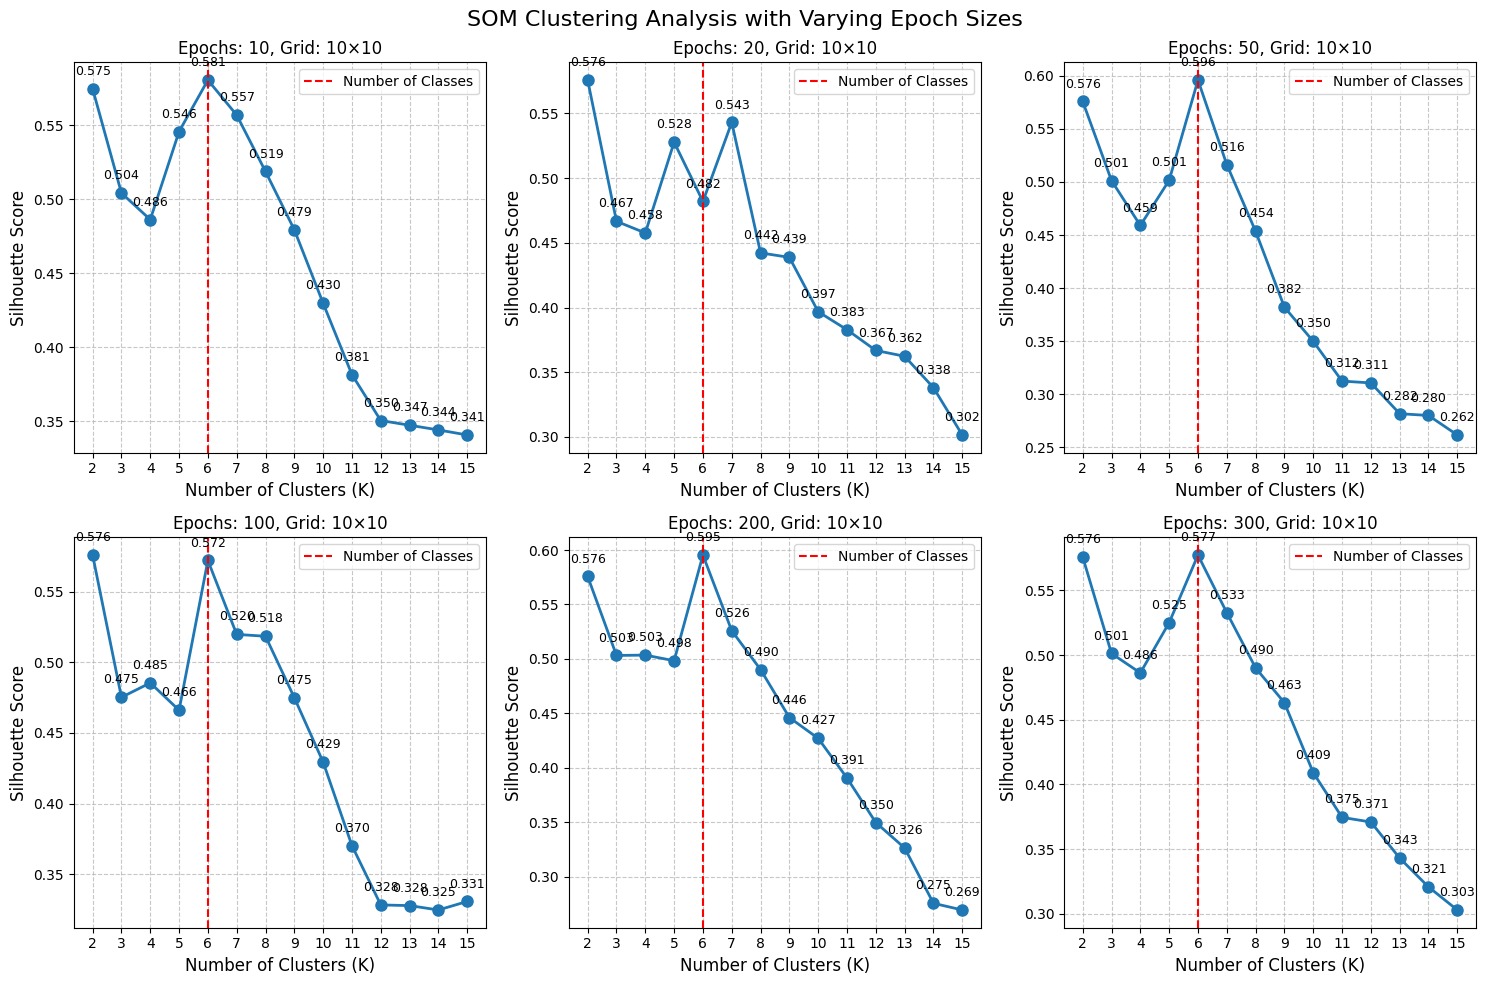

In [7]:
data = pd.read_csv(hexagon_path, header=1).values
classes = data[:, 2]
data = data[:, :2]

epoch_sizes = [10, 20, 50, 100, 200, 300]
unique_classes = len(np.unique(classes))
custom_grid_size = (10, 10)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

plt.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle("SOM Clustering Analysis with Varying Epoch Sizes", fontsize=16)

for idx, epoch_size in enumerate(epoch_sizes):
    cluster_sizes, silhouette_scores = analyze_som_clustering(
        data, 
        max_clusters=15, 
        grid_size=custom_grid_size,
        epochs=epoch_size
    )
    
    ax = axes[idx]
    ax.plot(cluster_sizes, silhouette_scores, marker='o', linestyle='-', linewidth=2, markersize=8)
    ax.set_xlabel('Number of Clusters (K)', fontsize=12)
    ax.set_ylabel('Silhouette Score', fontsize=12)
    ax.set_title(f'Epochs: {epoch_size}, Grid: {custom_grid_size[0]}×{custom_grid_size[1]}', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xticks(cluster_sizes)
    
    for i, score in enumerate(silhouette_scores):
        if not np.isnan(score):
            ax.annotate(f'{score:.3f}',
                    (cluster_sizes[i], score),
                    textcoords="offset points",
                    xytext=(0, 10),
                    ha='center',
                    fontsize=9)
    
    ax.axvline(x=unique_classes, color='r', linestyle='--', label='Number of Classes')
    ax.legend()
    
    valid_scores = [(k, score) for k, score in zip(cluster_sizes, silhouette_scores) if not np.isnan(score)]
    if valid_scores:
        best_k, best_score = max(valid_scores, key=lambda x: x[1])
        print(f"Epochs {epoch_size}: Optimal clusters = {best_k}, Silhouette score = {best_score:.3f}")
    else:
        print(f"Epochs {epoch_size}: No valid silhouette scores found")

plt.tight_layout()
plt.show()

#### Network size

Training SOM with fixed grid size 4x4...


Trening sieci: 100%|██████████| 100/100 [00:02<00:00, 46.80epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.576
Evaluating with 3 clusters...
  Silhouette score: 0.479
Evaluating with 4 clusters...
  Silhouette score: 0.448
Evaluating with 5 clusters...
  Silhouette score: 0.328
Evaluating with 6 clusters...
  Silhouette score: 0.304
Evaluating with 7 clusters...
  Silhouette score: 0.244
Evaluating with 8 clusters...
  Silhouette score: 0.217
Evaluating with 9 clusters...
  Silhouette score: 0.311
Evaluating with 10 clusters...
  Silhouette score: 0.306
Evaluating with 11 clusters...
  Silhouette score: 0.296
Evaluating with 12 clusters...
  Silhouette score: 0.270
Evaluating with 13 clusters...
  Silhouette score: 0.282
Evaluating with 14 clusters...
  Silhouette score: 0.284
Evaluating with 15 clusters...
  Silhouette score: 0.283
Epochs 100: Optimal clusters = 2, Silhouette score = 0.576
Training SOM with fixed grid size 6x6...


Trening sieci: 100%|██████████| 100/100 [00:02<00:00, 45.11epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.570
Evaluating with 3 clusters...
  Silhouette score: 0.503
Evaluating with 4 clusters...
  Silhouette score: 0.486
Evaluating with 5 clusters...
  Silhouette score: 0.518
Evaluating with 6 clusters...
  Silhouette score: 0.570
Evaluating with 7 clusters...
  Silhouette score: 0.542
Evaluating with 8 clusters...
  Silhouette score: 0.451
Evaluating with 9 clusters...
  Silhouette score: 0.463
Evaluating with 10 clusters...
  Silhouette score: 0.424
Evaluating with 11 clusters...
  Silhouette score: 0.418
Evaluating with 12 clusters...
  Silhouette score: 0.388
Evaluating with 13 clusters...
  Silhouette score: 0.342
Evaluating with 14 clusters...
  Silhouette score: 0.321
Evaluating with 15 clusters...
  Silhouette score: 0.319
Epochs 100: Optimal clusters = 2, Silhouette score = 0.570
Training SOM with fixed grid size 8x8...


Trening sieci: 100%|██████████| 100/100 [00:02<00:00, 42.08epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.573
Evaluating with 3 clusters...
  Silhouette score: 0.479
Evaluating with 4 clusters...
  Silhouette score: 0.478
Evaluating with 5 clusters...
  Silhouette score: 0.461
Evaluating with 6 clusters...
  Silhouette score: 0.583
Evaluating with 7 clusters...
  Silhouette score: 0.540
Evaluating with 8 clusters...
  Silhouette score: 0.481
Evaluating with 9 clusters...
  Silhouette score: 0.429
Evaluating with 10 clusters...
  Silhouette score: 0.403
Evaluating with 11 clusters...
  Silhouette score: 0.383
Evaluating with 12 clusters...
  Silhouette score: 0.335
Evaluating with 13 clusters...
  Silhouette score: 0.305
Evaluating with 14 clusters...
  Silhouette score: 0.294
Evaluating with 15 clusters...
  Silhouette score: 0.274
Epochs 100: Optimal clusters = 6, Silhouette score = 0.583
Training SOM with fixed grid size 10x10...


Trening sieci: 100%|██████████| 100/100 [00:02<00:00, 40.54epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.574
Evaluating with 3 clusters...
  Silhouette score: 0.444
Evaluating with 4 clusters...
  Silhouette score: 0.452
Evaluating with 5 clusters...
  Silhouette score: 0.471
Evaluating with 6 clusters...
  Silhouette score: 0.552
Evaluating with 7 clusters...
  Silhouette score: 0.501
Evaluating with 8 clusters...
  Silhouette score: 0.479
Evaluating with 9 clusters...
  Silhouette score: 0.468
Evaluating with 10 clusters...
  Silhouette score: 0.440
Evaluating with 11 clusters...
  Silhouette score: 0.413
Evaluating with 12 clusters...
  Silhouette score: 0.367
Evaluating with 13 clusters...
  Silhouette score: 0.368
Evaluating with 14 clusters...
  Silhouette score: 0.335
Evaluating with 15 clusters...
  Silhouette score: 0.331
Epochs 100: Optimal clusters = 2, Silhouette score = 0.574
Training SOM with fixed grid size 12x12...


Trening sieci: 100%|██████████| 100/100 [00:02<00:00, 37.64epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.576
Evaluating with 3 clusters...
  Silhouette score: 0.492
Evaluating with 4 clusters...
  Silhouette score: 0.478
Evaluating with 5 clusters...
  Silhouette score: 0.520
Evaluating with 6 clusters...
  Silhouette score: 0.594
Evaluating with 7 clusters...
  Silhouette score: 0.539
Evaluating with 8 clusters...
  Silhouette score: 0.494
Evaluating with 9 clusters...
  Silhouette score: 0.451
Evaluating with 10 clusters...
  Silhouette score: 0.407
Evaluating with 11 clusters...
  Silhouette score: 0.386
Evaluating with 12 clusters...
  Silhouette score: 0.348
Evaluating with 13 clusters...
  Silhouette score: 0.306
Evaluating with 14 clusters...
  Silhouette score: 0.284
Evaluating with 15 clusters...
  Silhouette score: 0.265
Epochs 100: Optimal clusters = 6, Silhouette score = 0.594
Training SOM with fixed grid size 14x14...


Trening sieci: 100%|██████████| 100/100 [00:02<00:00, 35.56epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.576
Evaluating with 3 clusters...
  Silhouette score: 0.476
Evaluating with 4 clusters...
  Silhouette score: 0.461
Evaluating with 5 clusters...
  Silhouette score: 0.532
Evaluating with 6 clusters...
  Silhouette score: 0.475
Evaluating with 7 clusters...
  Silhouette score: 0.543
Evaluating with 8 clusters...
  Silhouette score: 0.517
Evaluating with 9 clusters...
  Silhouette score: 0.476
Evaluating with 10 clusters...
  Silhouette score: 0.447
Evaluating with 11 clusters...
  Silhouette score: 0.398
Evaluating with 12 clusters...
  Silhouette score: 0.370
Evaluating with 13 clusters...
  Silhouette score: 0.357
Evaluating with 14 clusters...
  Silhouette score: 0.340
Evaluating with 15 clusters...
  Silhouette score: 0.323
Epochs 100: Optimal clusters = 2, Silhouette score = 0.576


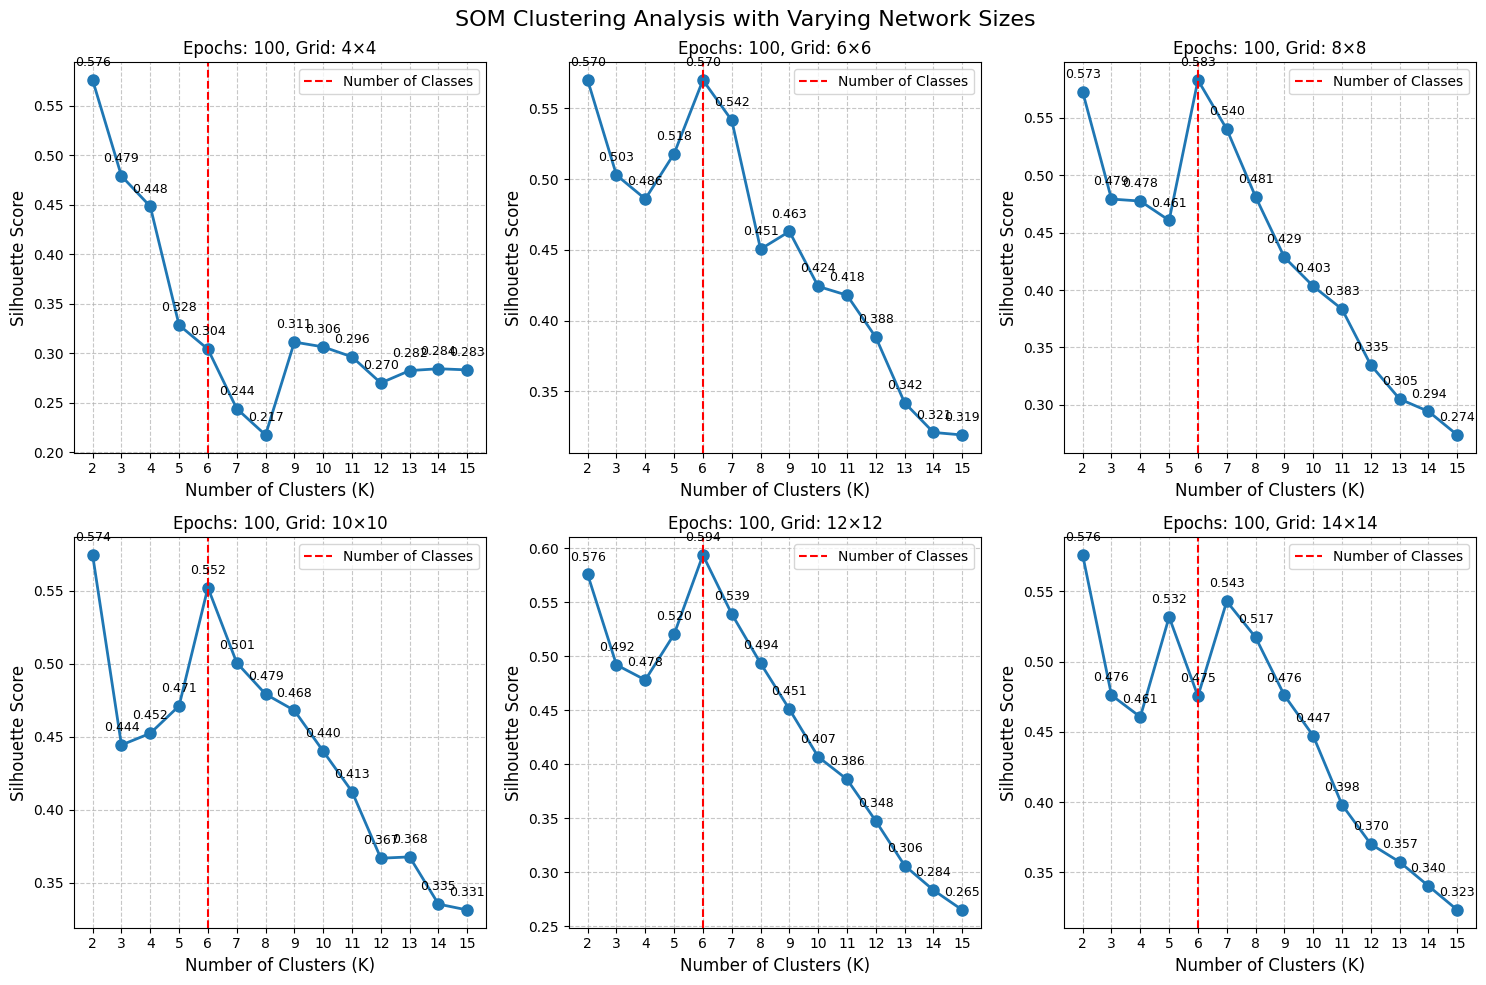

In [32]:
data = pd.read_csv(hexagon_path, header=1).values
classes = data[:, 2]
data = data[:, :2]

grid_sizes = [(4, 4), (6, 6), (8, 8), (10, 10), (12, 12), (14, 14)]
unique_classes = len(np.unique(classes))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

plt.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle("SOM Clustering Analysis with Varying Network Sizes", fontsize=16)

for idx, grid_size in enumerate(grid_sizes):
    cluster_sizes, silhouette_scores = analyze_som_clustering(
        data, 
        max_clusters=15, 
        grid_size=grid_size,
        epochs=100
    )
    
    ax = axes[idx]
    ax.plot(cluster_sizes, silhouette_scores, marker='o', linestyle='-', linewidth=2, markersize=8)
    ax.set_xlabel('Number of Clusters (K)', fontsize=12)
    ax.set_ylabel('Silhouette Score', fontsize=12)
    ax.set_title(f'Epochs: {epoch_size}, Grid: {grid_size[0]}×{grid_size[1]}', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xticks(cluster_sizes)
    
    for i, score in enumerate(silhouette_scores):
        if not np.isnan(score):
            ax.annotate(f'{score:.3f}',
                    (cluster_sizes[i], score),
                    textcoords="offset points",
                    xytext=(0, 10),
                    ha='center',
                    fontsize=9)
    
    ax.axvline(x=unique_classes, color='r', linestyle='--', label='Number of Classes')
    ax.legend()
    
    valid_scores = [(k, score) for k, score in zip(cluster_sizes, silhouette_scores) if not np.isnan(score)]
    if valid_scores:
        best_k, best_score = max(valid_scores, key=lambda x: x[1])
        print(f"Epochs {epoch_size}: Optimal clusters = {best_k}, Silhouette score = {best_score:.3f}")
    else:
        print(f"Epochs {epoch_size}: No valid silhouette scores found")

plt.tight_layout()
plt.show()

#### Neighbor function

Training SOM with fixed grid size 8x8...


Trening sieci: 100%|██████████| 100/100 [00:02<00:00, 43.48epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.576
Evaluating with 3 clusters...
  Silhouette score: 0.484
Evaluating with 4 clusters...
  Silhouette score: 0.442
Evaluating with 5 clusters...
  Silhouette score: 0.513
Evaluating with 6 clusters...
  Silhouette score: 0.592
Evaluating with 7 clusters...
  Silhouette score: 0.545
Evaluating with 8 clusters...
  Silhouette score: 0.497
Evaluating with 9 clusters...
  Silhouette score: 0.464
Evaluating with 10 clusters...
  Silhouette score: 0.403
Evaluating with 11 clusters...
  Silhouette score: 0.399
Evaluating with 12 clusters...
  Silhouette score: 0.350
Evaluating with 13 clusters...
  Silhouette score: 0.317
Evaluating with 14 clusters...
  Silhouette score: 0.311
Evaluating with 15 clusters...
  Silhouette score: 0.302
Epochs 100: Optimal clusters = 6, Silhouette score = 0.592
Training SOM with fixed grid size 8x8...


Trening sieci:   8%|▊         | 8/100 [00:00<00:02, 35.81epoka/s]C:\Users\admin\AppData\Local\Temp\ipykernel_25204\4041983673.py:83: RuntimeWarning: overflow encountered in square
  distances = np.sum((self.weights - x) ** 2, axis=2)
c:\nextcloud\Studia - PW\semestr 6\metody inteligencji obliczeniowej w analizie danych\H-_moje-github_sync-studia-Metody-inteligencji-obliczeniowej-w-analizie-danych\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
Trening sieci:  16%|█▌        | 16/100 [00:00<00:02, 35.70epoka/s]C:\Users\admin\AppData\Local\Temp\ipykernel_25204\4041983673.py:98: RuntimeWarning: overflow encountered in add
  self.weights += update
Trening sieci: 100%|██████████| 100/100 [00:02<00:00, 37.69epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.558
Evaluating with 3 clusters...
  Silhouette score: 0.247
Evaluating with 4 clusters...
  Silhouette score: 0.394
Evaluating with 5 clusters...
  Silhouette score: 0.509
Evaluating with 6 clusters...
  Silhouette score: 0.574
Evaluating with 7 clusters...
  Silhouette score: 0.528
Evaluating with 8 clusters...
  Silhouette score: 0.494
Evaluating with 9 clusters...
  Silhouette score: 0.463
Evaluating with 10 clusters...
  Silhouette score: 0.419
Evaluating with 11 clusters...
Evaluating with 12 clusters...
Evaluating with 13 clusters...
Evaluating with 14 clusters...
Evaluating with 15 clusters...
Epochs 100: Optimal clusters = 6, Silhouette score = 0.574


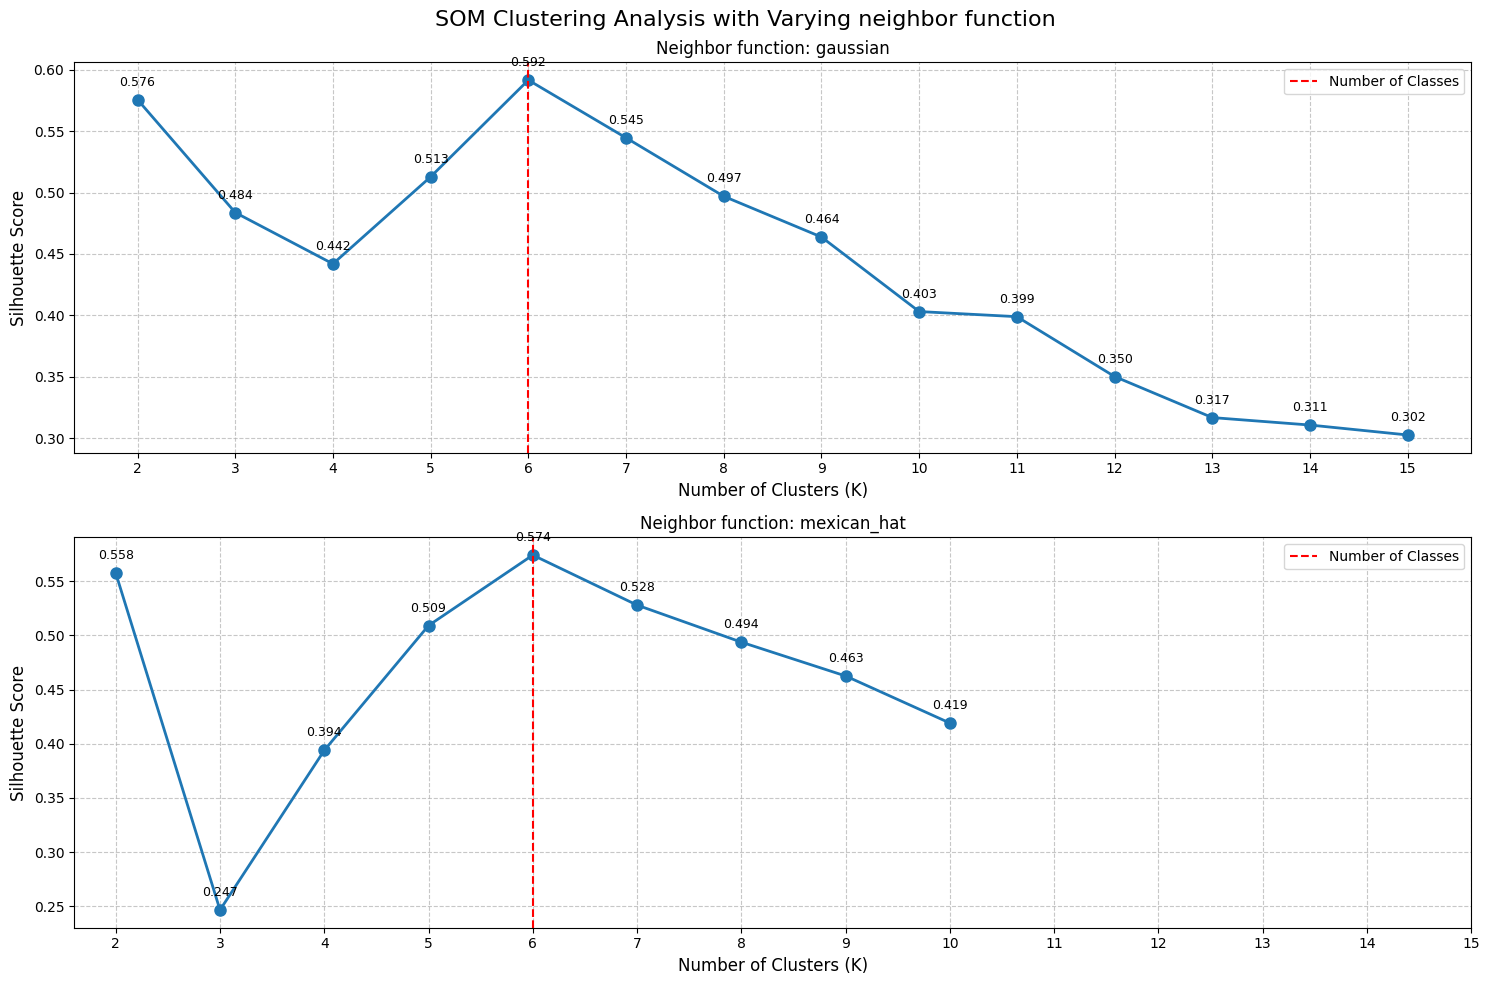

In [38]:
data = pd.read_csv(hexagon_path, header=1).values
classes = data[:, 2]
data = data[:, :2]

neighbor_functions = ['gaussian', 'mexican_hat']

unique_classes = len(np.unique(classes))
custom_grid_size = (8, 8)

fig, axes = plt.subplots(2, 1, figsize=(15, 10))
axes = axes.ravel()

epoch_size = 100

plt.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle("SOM Clustering Analysis with Varying neighbor function", fontsize=16)

for idx, neighbor_function in enumerate(neighbor_functions):
    cluster_sizes, silhouette_scores = analyze_som_clustering(
        data, 
        max_clusters=15, 
        grid_size=custom_grid_size,
        epochs=epoch_size,
        neighborhood_function=neighbor_function,
        neighbor_width=0.5
    )
    
    ax = axes[idx]
    ax.plot(cluster_sizes, silhouette_scores, marker='o', linestyle='-', linewidth=2, markersize=8)
    ax.set_xlabel('Number of Clusters (K)', fontsize=12)
    ax.set_ylabel('Silhouette Score', fontsize=12)
    ax.set_title(f'Neighbor function: {neighbor_function}', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xticks(cluster_sizes)
    
    for i, score in enumerate(silhouette_scores):
        if not np.isnan(score):
            ax.annotate(f'{score:.3f}',
                    (cluster_sizes[i], score),
                    textcoords="offset points",
                    xytext=(0, 10),
                    ha='center',
                    fontsize=9)
    
    ax.axvline(x=unique_classes, color='r', linestyle='--', label='Number of Classes')
    ax.legend()
    
    valid_scores = [(k, score) for k, score in zip(cluster_sizes, silhouette_scores) if not np.isnan(score)]
    if valid_scores:
        best_k, best_score = max(valid_scores, key=lambda x: x[1])
        print(f"Epochs {epoch_size}: Optimal clusters = {best_k}, Silhouette score = {best_score:.3f}")
    else:
        print(f"Epochs {epoch_size}: No valid silhouette scores found")

plt.tight_layout()
plt.show()

#### Topology & network size

In [18]:
network_sizes = [(4, 4), (6, 6), (8, 8), (10, 10), (12, 12), (14, 14)]
topologies = ['rectangular', 'hexagonal']

configs = [(size, topo) for size in network_sizes for topo in topologies]
for idx, config in enumerate(configs):
    print(config, config[0], config[1])

((4, 4), 'rectangular') (4, 4) rectangular
((4, 4), 'hexagonal') (4, 4) hexagonal
((6, 6), 'rectangular') (6, 6) rectangular
((6, 6), 'hexagonal') (6, 6) hexagonal
((8, 8), 'rectangular') (8, 8) rectangular
((8, 8), 'hexagonal') (8, 8) hexagonal
((10, 10), 'rectangular') (10, 10) rectangular
((10, 10), 'hexagonal') (10, 10) hexagonal
((12, 12), 'rectangular') (12, 12) rectangular
((12, 12), 'hexagonal') (12, 12) hexagonal
((14, 14), 'rectangular') (14, 14) rectangular
((14, 14), 'hexagonal') (14, 14) hexagonal


Training SOM with fixed grid size 4x4...


Trening sieci: 100%|██████████| 100/100 [00:02<00:00, 44.77epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.575
Evaluating with 3 clusters...
  Silhouette score: 0.418
Evaluating with 4 clusters...
  Silhouette score: 0.313
Evaluating with 5 clusters...
  Silhouette score: 0.268
Evaluating with 6 clusters...
  Silhouette score: 0.361
Evaluating with 7 clusters...
  Silhouette score: 0.470
Evaluating with 8 clusters...
  Silhouette score: 0.388
Evaluating with 9 clusters...
  Silhouette score: 0.392
Evaluating with 10 clusters...
  Silhouette score: 0.331
Evaluating with 11 clusters...
  Silhouette score: 0.336
Evaluating with 12 clusters...
  Silhouette score: 0.322
Evaluating with 13 clusters...
  Silhouette score: 0.325
Evaluating with 14 clusters...
  Silhouette score: 0.312
Evaluating with 15 clusters...
  Silhouette score: 0.294
Epochs 100: Optimal clusters = 2, Silhouette score = 0.575
Training SOM with fixed grid size 4x4...


Trening sieci: 100%|██████████| 100/100 [00:05<00:00, 18.47epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.485
Evaluating with 3 clusters...
  Silhouette score: 0.345
Evaluating with 4 clusters...
  Silhouette score: 0.459
Evaluating with 5 clusters...
  Silhouette score: 0.375
Evaluating with 6 clusters...
  Silhouette score: 0.369
Evaluating with 7 clusters...
  Silhouette score: 0.327
Evaluating with 8 clusters...
  Silhouette score: 0.309
Evaluating with 9 clusters...
  Silhouette score: 0.317
Evaluating with 10 clusters...
  Silhouette score: 0.285
Evaluating with 11 clusters...
  Silhouette score: 0.269
Evaluating with 12 clusters...
  Silhouette score: 0.257
Evaluating with 13 clusters...
  Silhouette score: 0.308
Evaluating with 14 clusters...
  Silhouette score: 0.268
Evaluating with 15 clusters...
  Silhouette score: 0.260
Epochs 100: Optimal clusters = 2, Silhouette score = 0.485
Training SOM with fixed grid size 6x6...


Trening sieci: 100%|██████████| 100/100 [00:02<00:00, 39.72epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.574
Evaluating with 3 clusters...
  Silhouette score: 0.488
Evaluating with 4 clusters...
  Silhouette score: 0.443
Evaluating with 5 clusters...
  Silhouette score: 0.503
Evaluating with 6 clusters...
  Silhouette score: 0.488
Evaluating with 7 clusters...
  Silhouette score: 0.446
Evaluating with 8 clusters...
  Silhouette score: 0.411
Evaluating with 9 clusters...
  Silhouette score: 0.454
Evaluating with 10 clusters...
  Silhouette score: 0.407
Evaluating with 11 clusters...
  Silhouette score: 0.394
Evaluating with 12 clusters...
  Silhouette score: 0.401
Evaluating with 13 clusters...
  Silhouette score: 0.358
Evaluating with 14 clusters...
  Silhouette score: 0.363
Evaluating with 15 clusters...
  Silhouette score: 0.344
Epochs 100: Optimal clusters = 2, Silhouette score = 0.574
Training SOM with fixed grid size 6x6...


Trening sieci: 100%|██████████| 100/100 [00:10<00:00,  9.70epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.576
Evaluating with 3 clusters...
  Silhouette score: 0.498
Evaluating with 4 clusters...
  Silhouette score: 0.419
Evaluating with 5 clusters...
  Silhouette score: 0.386
Evaluating with 6 clusters...
  Silhouette score: 0.422
Evaluating with 7 clusters...
  Silhouette score: 0.461
Evaluating with 8 clusters...
  Silhouette score: 0.443
Evaluating with 9 clusters...
  Silhouette score: 0.417
Evaluating with 10 clusters...
  Silhouette score: 0.364
Evaluating with 11 clusters...
  Silhouette score: 0.358
Evaluating with 12 clusters...
  Silhouette score: 0.343
Evaluating with 13 clusters...
  Silhouette score: 0.299
Evaluating with 14 clusters...
  Silhouette score: 0.315
Evaluating with 15 clusters...
  Silhouette score: 0.304
Epochs 100: Optimal clusters = 2, Silhouette score = 0.576
Training SOM with fixed grid size 8x8...


Trening sieci: 100%|██████████| 100/100 [00:02<00:00, 40.98epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.574
Evaluating with 3 clusters...
  Silhouette score: 0.498
Evaluating with 4 clusters...
  Silhouette score: 0.481
Evaluating with 5 clusters...
  Silhouette score: 0.515
Evaluating with 6 clusters...
  Silhouette score: 0.547
Evaluating with 7 clusters...
  Silhouette score: 0.496
Evaluating with 8 clusters...
  Silhouette score: 0.449
Evaluating with 9 clusters...
  Silhouette score: 0.411
Evaluating with 10 clusters...
  Silhouette score: 0.380
Evaluating with 11 clusters...
  Silhouette score: 0.351
Evaluating with 12 clusters...
  Silhouette score: 0.337
Evaluating with 13 clusters...
  Silhouette score: 0.313
Evaluating with 14 clusters...
  Silhouette score: 0.315
Evaluating with 15 clusters...
  Silhouette score: 0.303
Epochs 100: Optimal clusters = 2, Silhouette score = 0.574
Training SOM with fixed grid size 8x8...


Trening sieci: 100%|██████████| 100/100 [00:15<00:00,  6.29epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.574
Evaluating with 3 clusters...
  Silhouette score: 0.488
Evaluating with 4 clusters...
  Silhouette score: 0.469
Evaluating with 5 clusters...
  Silhouette score: 0.537
Evaluating with 6 clusters...
  Silhouette score: 0.454
Evaluating with 7 clusters...
  Silhouette score: 0.501
Evaluating with 8 clusters...
  Silhouette score: 0.499
Evaluating with 9 clusters...
  Silhouette score: 0.464
Evaluating with 10 clusters...
  Silhouette score: 0.451
Evaluating with 11 clusters...
  Silhouette score: 0.380
Evaluating with 12 clusters...
  Silhouette score: 0.328
Evaluating with 13 clusters...
  Silhouette score: 0.284
Evaluating with 14 clusters...
  Silhouette score: 0.279
Evaluating with 15 clusters...
  Silhouette score: 0.292
Epochs 100: Optimal clusters = 2, Silhouette score = 0.574
Training SOM with fixed grid size 10x10...


Trening sieci: 100%|██████████| 100/100 [00:02<00:00, 40.65epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.576
Evaluating with 3 clusters...
  Silhouette score: 0.501
Evaluating with 4 clusters...
  Silhouette score: 0.450
Evaluating with 5 clusters...
  Silhouette score: 0.489
Evaluating with 6 clusters...
  Silhouette score: 0.585
Evaluating with 7 clusters...
  Silhouette score: 0.527
Evaluating with 8 clusters...
  Silhouette score: 0.482
Evaluating with 9 clusters...
  Silhouette score: 0.471
Evaluating with 10 clusters...
  Silhouette score: 0.425
Evaluating with 11 clusters...
  Silhouette score: 0.390
Evaluating with 12 clusters...
  Silhouette score: 0.393
Evaluating with 13 clusters...
  Silhouette score: 0.339
Evaluating with 14 clusters...
  Silhouette score: 0.337
Evaluating with 15 clusters...
  Silhouette score: 0.328
Epochs 100: Optimal clusters = 6, Silhouette score = 0.585
Training SOM with fixed grid size 10x10...


Trening sieci: 100%|██████████| 100/100 [00:24<00:00,  4.06epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.575
Evaluating with 3 clusters...
  Silhouette score: 0.469
Evaluating with 4 clusters...
  Silhouette score: 0.439
Evaluating with 5 clusters...
  Silhouette score: 0.512
Evaluating with 6 clusters...
  Silhouette score: 0.587
Evaluating with 7 clusters...
  Silhouette score: 0.545
Evaluating with 8 clusters...
  Silhouette score: 0.459
Evaluating with 9 clusters...
  Silhouette score: 0.410
Evaluating with 10 clusters...
  Silhouette score: 0.364
Evaluating with 11 clusters...
  Silhouette score: 0.362
Evaluating with 12 clusters...
  Silhouette score: 0.346
Evaluating with 13 clusters...
  Silhouette score: 0.335
Evaluating with 14 clusters...
  Silhouette score: 0.324
Evaluating with 15 clusters...
  Silhouette score: 0.306
Epochs 100: Optimal clusters = 6, Silhouette score = 0.587
Training SOM with fixed grid size 12x12...


Trening sieci: 100%|██████████| 100/100 [00:02<00:00, 35.13epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.576
Evaluating with 3 clusters...
  Silhouette score: 0.502
Evaluating with 4 clusters...
  Silhouette score: 0.485
Evaluating with 5 clusters...
  Silhouette score: 0.517
Evaluating with 6 clusters...
  Silhouette score: 0.575
Evaluating with 7 clusters...
  Silhouette score: 0.527
Evaluating with 8 clusters...
  Silhouette score: 0.481
Evaluating with 9 clusters...
  Silhouette score: 0.460
Evaluating with 10 clusters...
  Silhouette score: 0.419
Evaluating with 11 clusters...
  Silhouette score: 0.403
Evaluating with 12 clusters...
  Silhouette score: 0.359
Evaluating with 13 clusters...
  Silhouette score: 0.345
Evaluating with 14 clusters...
  Silhouette score: 0.338
Evaluating with 15 clusters...
  Silhouette score: 0.315
Epochs 100: Optimal clusters = 2, Silhouette score = 0.576
Training SOM with fixed grid size 12x12...


Trening sieci: 100%|██████████| 100/100 [00:34<00:00,  2.87epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.576
Evaluating with 3 clusters...
  Silhouette score: 0.487
Evaluating with 4 clusters...
  Silhouette score: 0.487
Evaluating with 5 clusters...
  Silhouette score: 0.544
Evaluating with 6 clusters...
  Silhouette score: 0.481
Evaluating with 7 clusters...
  Silhouette score: 0.551
Evaluating with 8 clusters...
  Silhouette score: 0.508
Evaluating with 9 clusters...
  Silhouette score: 0.452
Evaluating with 10 clusters...
  Silhouette score: 0.416
Evaluating with 11 clusters...
  Silhouette score: 0.396
Evaluating with 12 clusters...
  Silhouette score: 0.356
Evaluating with 13 clusters...
  Silhouette score: 0.334
Evaluating with 14 clusters...
  Silhouette score: 0.331
Evaluating with 15 clusters...
  Silhouette score: 0.323
Epochs 100: Optimal clusters = 2, Silhouette score = 0.576
Training SOM with fixed grid size 14x14...


Trening sieci: 100%|██████████| 100/100 [00:02<00:00, 34.00epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.576
Evaluating with 3 clusters...
  Silhouette score: 0.473
Evaluating with 4 clusters...
  Silhouette score: 0.452
Evaluating with 5 clusters...
  Silhouette score: 0.519
Evaluating with 6 clusters...
  Silhouette score: 0.477
Evaluating with 7 clusters...
  Silhouette score: 0.553
Evaluating with 8 clusters...
  Silhouette score: 0.485
Evaluating with 9 clusters...
  Silhouette score: 0.454
Evaluating with 10 clusters...
  Silhouette score: 0.436
Evaluating with 11 clusters...
  Silhouette score: 0.417
Evaluating with 12 clusters...
  Silhouette score: 0.394
Evaluating with 13 clusters...
  Silhouette score: 0.377
Evaluating with 14 clusters...
  Silhouette score: 0.364
Evaluating with 15 clusters...
  Silhouette score: 0.351
Epochs 100: Optimal clusters = 2, Silhouette score = 0.576
Training SOM with fixed grid size 14x14...


Trening sieci: 100%|██████████| 100/100 [00:44<00:00,  2.24epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.576
Evaluating with 3 clusters...
  Silhouette score: 0.502
Evaluating with 4 clusters...
  Silhouette score: 0.531
Evaluating with 5 clusters...
  Silhouette score: 0.544
Evaluating with 6 clusters...
  Silhouette score: 0.592
Evaluating with 7 clusters...
  Silhouette score: 0.539
Evaluating with 8 clusters...
  Silhouette score: 0.483
Evaluating with 9 clusters...
  Silhouette score: 0.451
Evaluating with 10 clusters...
  Silhouette score: 0.414
Evaluating with 11 clusters...
  Silhouette score: 0.387
Evaluating with 12 clusters...
  Silhouette score: 0.350
Evaluating with 13 clusters...
  Silhouette score: 0.343
Evaluating with 14 clusters...
  Silhouette score: 0.315
Evaluating with 15 clusters...
  Silhouette score: 0.301
Epochs 100: Optimal clusters = 6, Silhouette score = 0.592


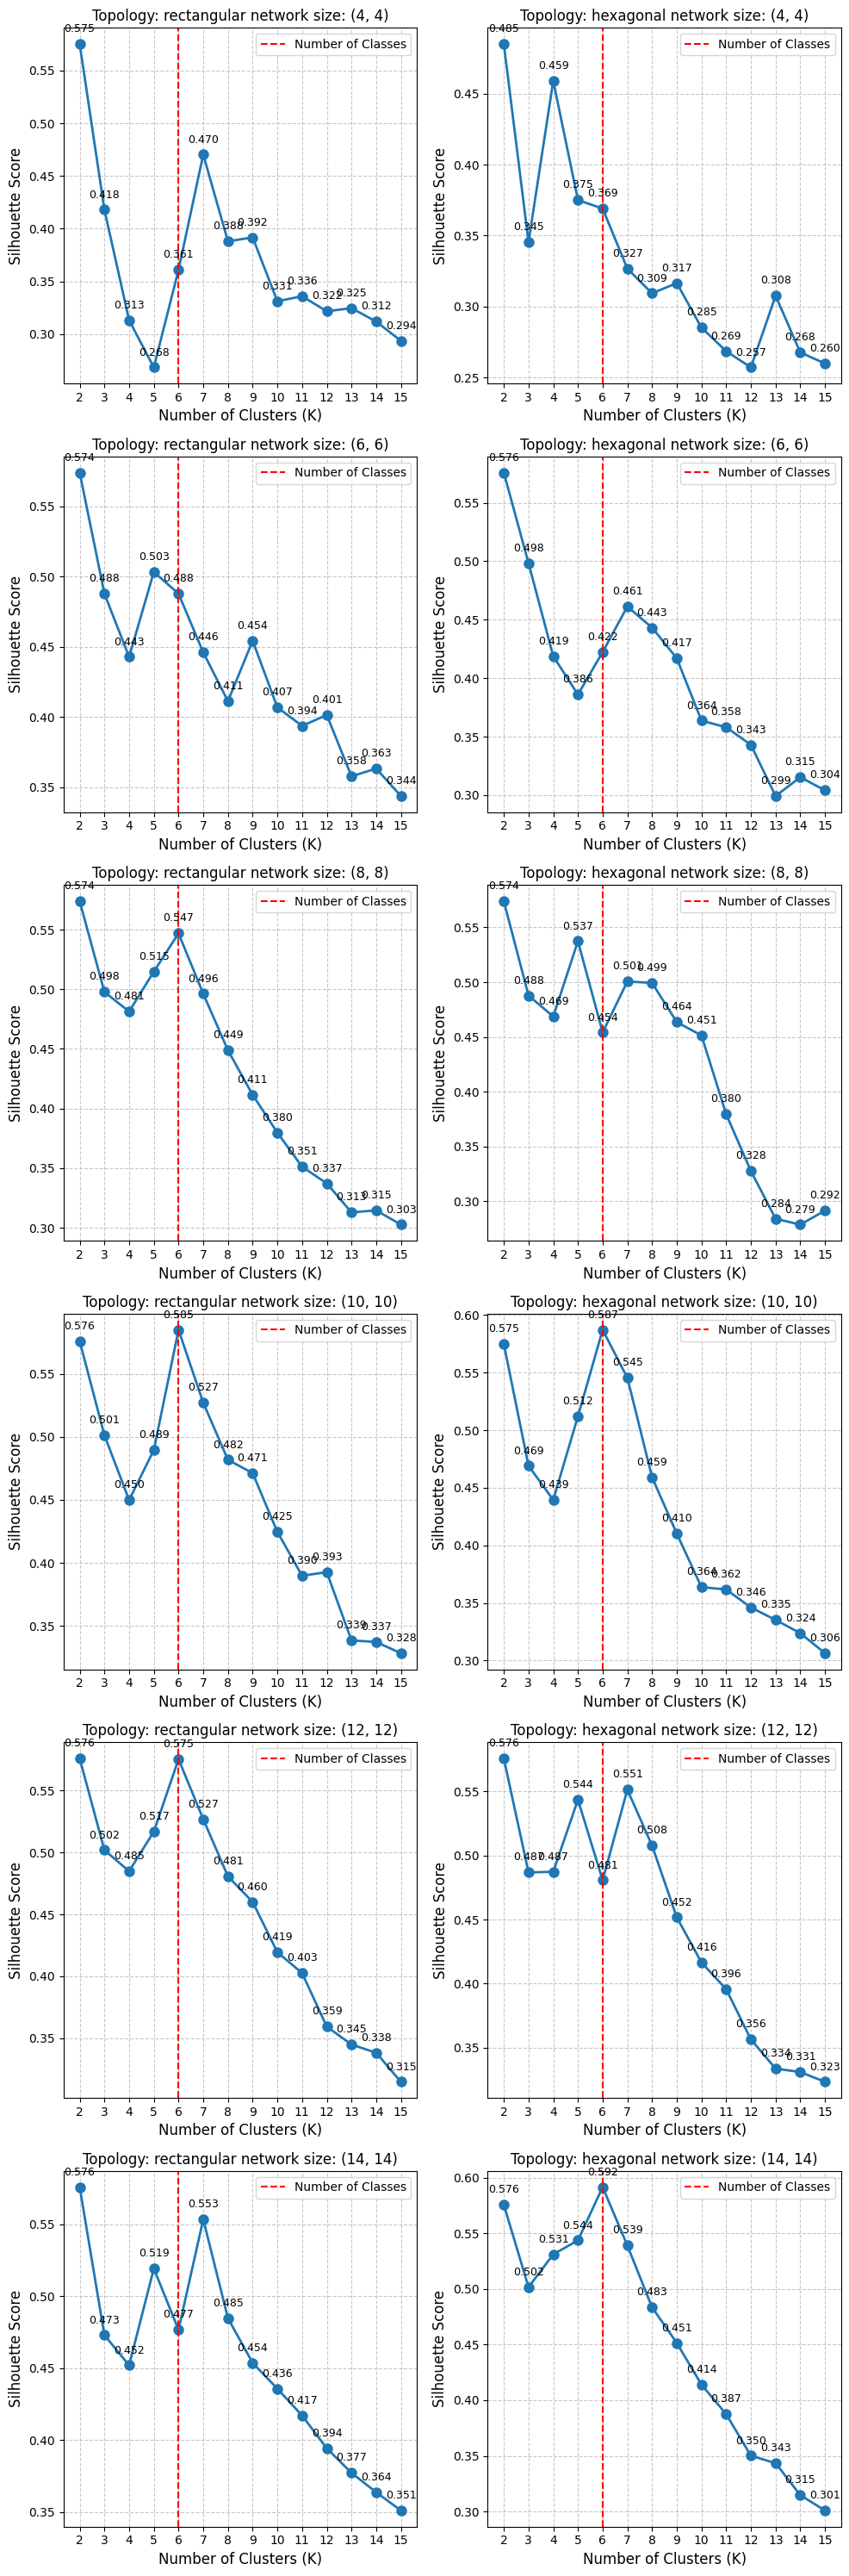

In [ ]:
data = pd.read_csv(hexagon_path, header=1).values
classes = data[:, 2]
data = data[:, :2]

network_sizes = [(4, 4), (6, 6), (8, 8), (10, 10), (12, 12), (14, 14)]
topologies = ['rectangular', 'hexagonal']

configs = [(size, topo) for size in network_sizes for topo in topologies]

unique_classes = len(np.unique(classes))

fig, axes = plt.subplots(6, 2, figsize=(10, 30))
axes = axes.ravel()

epoch_size = 100

plt.subplots_adjust(hspace=0.4, wspace=0.4)

for idx, config in enumerate(configs):
    cluster_sizes, silhouette_scores = analyze_som_clustering(
        data, 
        max_clusters=15, 
        grid_size=config[0],
        epochs=epoch_size,
        neighborhood_function='gaussian',
        topology=config[1],
        
    )
    
    ax = axes[idx]
    ax.plot(cluster_sizes, silhouette_scores, marker='o', linestyle='-', linewidth=2, markersize=8)
    ax.set_xlabel('Number of Clusters (K)', fontsize=12)
    ax.set_ylabel('Silhouette Score', fontsize=12)
    ax.set_title(f'Topology: {config[1]} network size: {config[0]}', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xticks(cluster_sizes)
    
    for i, score in enumerate(silhouette_scores):
        if not np.isnan(score):
            ax.annotate(f'{score:.3f}',
                    (cluster_sizes[i], score),
                    textcoords="offset points",
                    xytext=(0, 10),
                    ha='center',
                    fontsize=9)
    
    ax.axvline(x=unique_classes, color='r', linestyle='--', label='Number of Classes')
    ax.legend()
    
    valid_scores = [(k, score) for k, score in zip(cluster_sizes, silhouette_scores) if not np.isnan(score)]
    if valid_scores:
        best_k, best_score = max(valid_scores, key=lambda x: x[1])
        print(f"Epochs {epoch_size}: Optimal clusters = {best_k}, Silhouette score = {best_score:.3f}")
    else:
        print(f"Epochs {epoch_size}: No valid silhouette scores found")

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
for epoch_size in epoch_sizes:
    cluster_sizes, silhouette_scores = analyze_som_clustering(
        data, 
        max_clusters=15, 
        grid_size=custom_grid_size,
        epochs=epoch_size
    )
    valid_indices = [i for i, score in enumerate(silhouette_scores) if not np.isnan(score)]
    valid_clusters = [cluster_sizes[i] for i in valid_indices]
    valid_scores = [silhouette_scores[i] for i in valid_indices]
    plt.plot(valid_clusters, valid_scores, marker='o', linestyle='-', linewidth=2, 
             label=f'Epochs: {epoch_size}')

plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Comparison of Silhouette Scores Across Different Epoch Sizes', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axvline(x=unique_classes, color='r', linestyle='--', label='Number of Classes', linewidth=2)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
unique_classes = len(np.unique(classes))
custom_grid_size = (10, 10)
cluster_sizes, silhouette_scores = analyze_som_clustering(data, max_clusters=15, grid_size=custom_grid_size)

plt.figure(figsize=(10, 6))
plt.plot(cluster_sizes, silhouette_scores, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title(f'Silhouette Score vs. Number of Clusters (Fixed SOM Grid {custom_grid_size[0]}×{custom_grid_size[1]})', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(cluster_sizes)

for i, score in enumerate(silhouette_scores):
    if not np.isnan(score):
        plt.annotate(f'{score:.3f}', 
                   (cluster_sizes[i], score),
                   textcoords="offset points", 
                   xytext=(0, 10), 
                   ha='center')

plt.axhline(y=1/unique_classes, color='r', linestyle='--', label='Number of Classes')
plt.legend()
plt.tight_layout()
plt.show()

valid_scores = [(k, score) for k, score in zip(cluster_sizes, silhouette_scores) if not np.isnan(score)]
if valid_scores:
    best_k, best_score = max(valid_scores, key=lambda x: x[1])
    print(f"\nOptimal number of clusters: {best_k} with silhouette score: {best_score:.3f}")
else:
    print("No valid silhouette scores found")

In [ ]:
silhoutete_scores = []
for i in range(2, 11):
    som_hex = KohonenNetwork(input_dim=data.shape[1], grid_size=(i, i), 
                              topology='rectangular', neighborhood_function='gaussian')
    som_hex.train(data, epochs=100)
    silhoutete_scores.append(float(som_hex.calculate_silhouette_score(data)['silhouette_score']))

plt.figure(figsize=(8, 6))
plt.plot(range(1, 10), silhoutete_scores, marker='o')

In [ ]:
cluster_sizes, silhouette_scores = analyze_som_clustering(data, max_clusters=15, grid_size=(6, 6))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(cluster_sizes, silhouette_scores, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title(f'Silhouette Score vs. Number of Clusters (Fixed SOM Grid {grid_size[0]}×{grid_size[1]})', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(cluster_sizes)

# Add value annotations
for i, score in enumerate(silhouette_scores):
    if not np.isnan(score):  # Only annotate non-NaN values
        plt.annotate(f'{score:.3f}', 
                   (cluster_sizes[i], score),
                   textcoords="offset points", 
                   xytext=(0, 10), 
                   ha='center')

plt.tight_layout()
plt.show()

# Find the optimal number of clusters
valid_scores = [(k, score) for k, score in zip(cluster_sizes, silhouette_scores) if not np.isnan(score)]
if valid_scores:
    best_k, best_score = max(valid_scores, key=lambda x: x[1])
    print(f"\nOptimal number of clusters: {best_k} with silhouette score: {best_score:.3f}")
else:
    print("No valid silhouette scores found")

In [ ]:
cluster_sizes, silhouette_scores = analyze_som_clustering(data, max_clusters=15, grid_size=(8, 8))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(cluster_sizes, silhouette_scores, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title(f'Silhouette Score vs. Number of Clusters (Fixed SOM Grid {grid_size[0]}×{grid_size[1]})', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(cluster_sizes)

# Add value annotations
for i, score in enumerate(silhouette_scores):
    if not np.isnan(score):  # Only annotate non-NaN values
        plt.annotate(f'{score:.3f}', 
                   (cluster_sizes[i], score),
                   textcoords="offset points", 
                   xytext=(0, 10), 
                   ha='center')

plt.tight_layout()
plt.show()

# Find the optimal number of clusters
valid_scores = [(k, score) for k, score in zip(cluster_sizes, silhouette_scores) if not np.isnan(score)]
if valid_scores:
    best_k, best_score = max(valid_scores, key=lambda x: x[1])
    print(f"\nOptimal number of clusters: {best_k} with silhouette score: {best_score:.3f}")
else:
    print("No valid silhouette scores found")

In [ ]:
silhoutete_scores = []
for i in range(2, 11):
    som_hex = KohonenNetwork(input_dim=data.shape[1], grid_size=(i, i), 
                              topology='hexagonal', neighborhood_function='gaussian')
    som_hex.train(data, epochs=100)
    silhoutete_scores.append(float(som_hex.calculate_silhouette_score(data)['silhouette_score']))

plt.figure(figsize=(8, 6))
plt.plot(range(1, 10), silhoutete_scores, marker='o')

### KOH 2

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import pandas as pd
import os
from sklearn.datasets import fetch_openml
def load_mnist_data():
    """Załaduj dane MNIST"""
    mnist = fetch_openml('mnist_784', version=1, parser='auto')
    x_data = mnist.data.to_numpy().astype('float32') / 255.0  # Dodane .to_numpy() aby upewnić się, że dane są w formacie numpy array
    y_train = mnist.target.to_numpy().astype(int)  # Dodane .to_numpy() aby upewnić się, że etykiety są w formacie numpy array
   
    x_data = x_data[:6000]
    y_train = y_train[:6000]
    pca = PCA(n_components=50)
    x_data_pca = pca.fit_transform(x_data)
   
    return x_data_pca, y_train

def load_har_data():
    """Załaduj dane Human Activity Recognition"""
    features_file = 'data/UCI HAR Dataset/train/X_train.txt'
    labels_file = 'data/UCI HAR Dataset/train/y_train.txt'
   
    if os.path.exists(features_file) and os.path.exists(labels_file):
        X = pd.read_csv(features_file, sep=r'\s+', header=None)
        y = pd.read_csv(labels_file, header=None).values.ravel()
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X.values)
        return X_scaled, y - 1  # Dostosuj etykiety do 0-based indexing
    else:
        print("Pliki HAR nie zostały znalezione. Użyj odpowiednich ścieżek.")
        return None, None


In [52]:
minst_data, mnist_labels = load_mnist_data()
har_data, har_labels = load_har_data()

In [53]:
print("MNIST data shape:", minist_data.shape)
print("HAR data shape:", har_data.shape)

MNIST data shape: (6000, 50)
HAR data shape: (7352, 561)


Training SOM with fixed grid size 20x20...


Trening sieci: 100%|██████████| 200/200 [02:12<00:00,  1.51epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.057
Evaluating with 3 clusters...
  Silhouette score: 0.060
Evaluating with 4 clusters...
  Silhouette score: 0.068
Evaluating with 5 clusters...
  Silhouette score: 0.069
Evaluating with 6 clusters...
  Silhouette score: 0.062
Evaluating with 7 clusters...
  Silhouette score: 0.076
Evaluating with 8 clusters...
  Silhouette score: 0.077
Evaluating with 9 clusters...
  Silhouette score: 0.079
Evaluating with 10 clusters...
  Silhouette score: 0.066
Evaluating with 11 clusters...
  Silhouette score: 0.069
Evaluating with 12 clusters...
  Silhouette score: 0.067
Evaluating with 13 clusters...
  Silhouette score: 0.070
Evaluating with 14 clusters...
  Silhouette score: 0.069
Evaluating with 15 clusters...
  Silhouette score: 0.067
Optimal number of clusters: 9 with silhouette score: 0.079


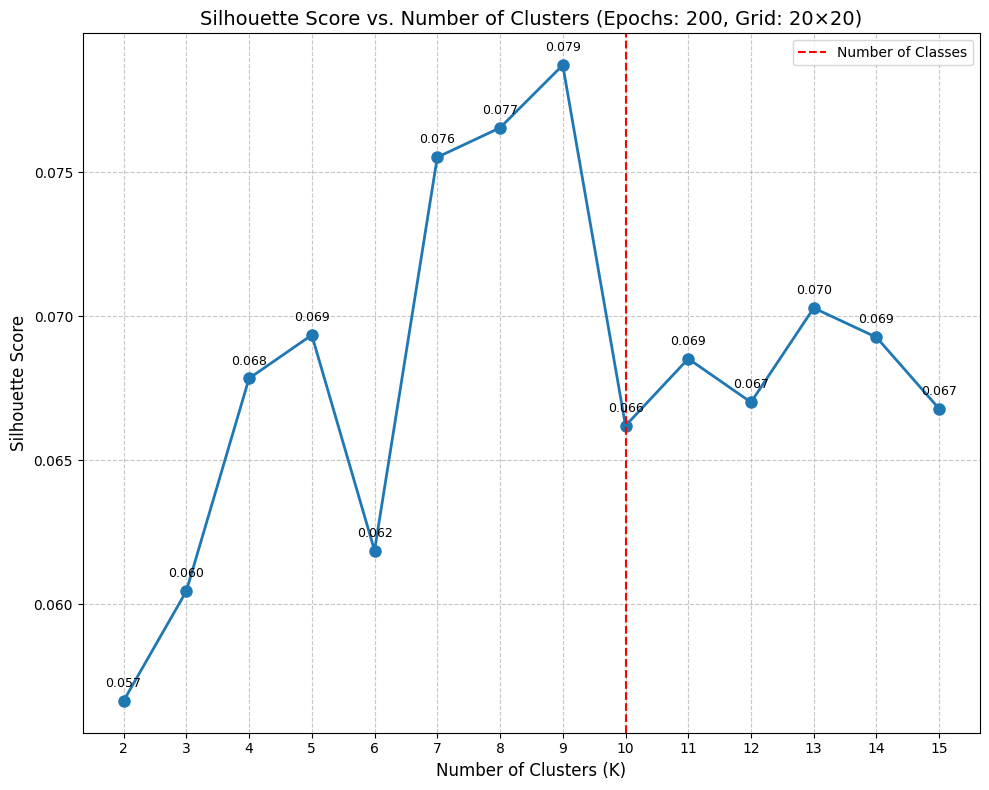

In [54]:
classes = mnist_labels
data = minst_data

unique_classes = len(np.unique(classes))

grid_size = (20, 20)
epoch_size = 200
plt.figure(figsize=(10, 8))
plt.title("Cluster Number Analysis", fontsize=16)
cluster_sizes, silhouette_scores = analyze_som_clustering(
    data,
    max_clusters=15,
    grid_size=grid_size,
    epochs=epoch_size
)

plt.plot(cluster_sizes, silhouette_scores, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title(f'Silhouette Score vs. Number of Clusters (Epochs: {epoch_size}, Grid: {grid_size[0]}×{grid_size[1]})', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(cluster_sizes)

for i, score in enumerate(silhouette_scores):
    if not np.isnan(score):
        plt.annotate(f'{score:.3f}',
                (cluster_sizes[i], score),
                textcoords="offset points",
                xytext=(0, 10),
                ha='center',
                fontsize=9)
plt.axvline(x=unique_classes, color='r', linestyle='--', label='Number of Classes')
plt.legend()

valid_scores = [(k, score) for k, score in zip(cluster_sizes, silhouette_scores) if not np.isnan(score)]
if valid_scores:
    best_k, best_score = max(valid_scores, key=lambda x: x[1])
    print(f"Optimal number of clusters: {best_k} with silhouette score: {best_score:.3f}")
else:
    print("No valid silhouette scores found")

plt.tight_layout()
plt.show()

Training SOM with fixed grid size 10x10...


Trening sieci:   0%|          | 0/100 [00:00<?, ?epoka/s]

Trening sieci: 100%|██████████| 100/100 [02:34<00:00,  1.54s/epoka]


Evaluating with 2 clusters...
  Silhouette score: 0.481
Evaluating with 3 clusters...
  Silhouette score: 0.306
Evaluating with 4 clusters...
  Silhouette score: 0.217
Evaluating with 5 clusters...
  Silhouette score: 0.158
Evaluating with 6 clusters...
  Silhouette score: 0.150
Evaluating with 7 clusters...
  Silhouette score: 0.139
Evaluating with 8 clusters...
  Silhouette score: 0.138
Evaluating with 9 clusters...
  Silhouette score: 0.128
Evaluating with 10 clusters...
  Silhouette score: 0.121
Evaluating with 11 clusters...
  Silhouette score: 0.118
Evaluating with 12 clusters...
  Silhouette score: 0.059
Evaluating with 13 clusters...
  Silhouette score: 0.060
Evaluating with 14 clusters...
  Silhouette score: 0.057
Evaluating with 15 clusters...
  Silhouette score: 0.056
Optimal number of clusters: 2 with silhouette score: 0.481


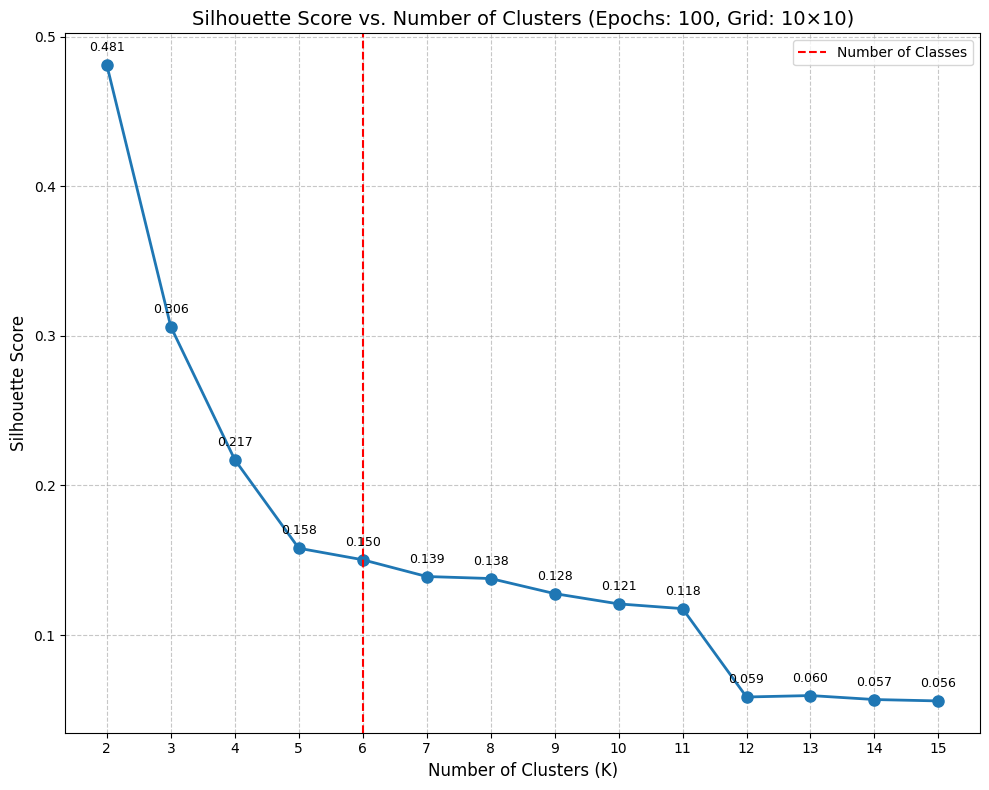

In [57]:
classes = har_labels
data = har_data

unique_classes = len(np.unique(classes))

grid_size = (10, 10)
epoch_size = 100
plt.figure(figsize=(10, 8))
plt.title("Cluster Number Analysis", fontsize=16)
cluster_sizes, silhouette_scores = analyze_som_clustering(
    data,
    max_clusters=15,
    grid_size=grid_size,
    epochs=epoch_size
)

plt.plot(cluster_sizes, silhouette_scores, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title(f'Silhouette Score vs. Number of Clusters (Epochs: {epoch_size}, Grid: {grid_size[0]}×{grid_size[1]})', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(cluster_sizes)

for i, score in enumerate(silhouette_scores):
    if not np.isnan(score):
        plt.annotate(f'{score:.3f}',
                (cluster_sizes[i], score),
                textcoords="offset points",
                xytext=(0, 10),
                ha='center',
                fontsize=9)
plt.axvline(x=unique_classes, color='r', linestyle='--', label='Number of Classes')
plt.legend()

valid_scores = [(k, score) for k, score in zip(cluster_sizes, silhouette_scores) if not np.isnan(score)]
if valid_scores:
    best_k, best_score = max(valid_scores, key=lambda x: x[1])
    print(f"Optimal number of clusters: {best_k} with silhouette score: {best_score:.3f}")
else:
    print("No valid silhouette scores found")

plt.tight_layout()
plt.show()

Training SOM with fixed grid size 5x5...


Trening sieci: 100%|██████████| 200/200 [00:17<00:00, 11.50epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.485
Evaluating with 3 clusters...
  Silhouette score: 0.283
Evaluating with 4 clusters...
  Silhouette score: 0.155
Evaluating with 5 clusters...
  Silhouette score: 0.093
Evaluating with 6 clusters...
  Silhouette score: 0.097
Evaluating with 7 clusters...
  Silhouette score: 0.090
Evaluating with 8 clusters...
  Silhouette score: 0.056
Evaluating with 9 clusters...
  Silhouette score: 0.052
Evaluating with 10 clusters...
  Silhouette score: 0.053
Evaluating with 11 clusters...
  Silhouette score: 0.040
Evaluating with 12 clusters...
  Silhouette score: 0.022
Evaluating with 13 clusters...
  Silhouette score: 0.023
Evaluating with 14 clusters...
  Silhouette score: 0.018
Evaluating with 15 clusters...
  Silhouette score: 0.017
Optimal number of clusters: 2 with silhouette score: 0.485


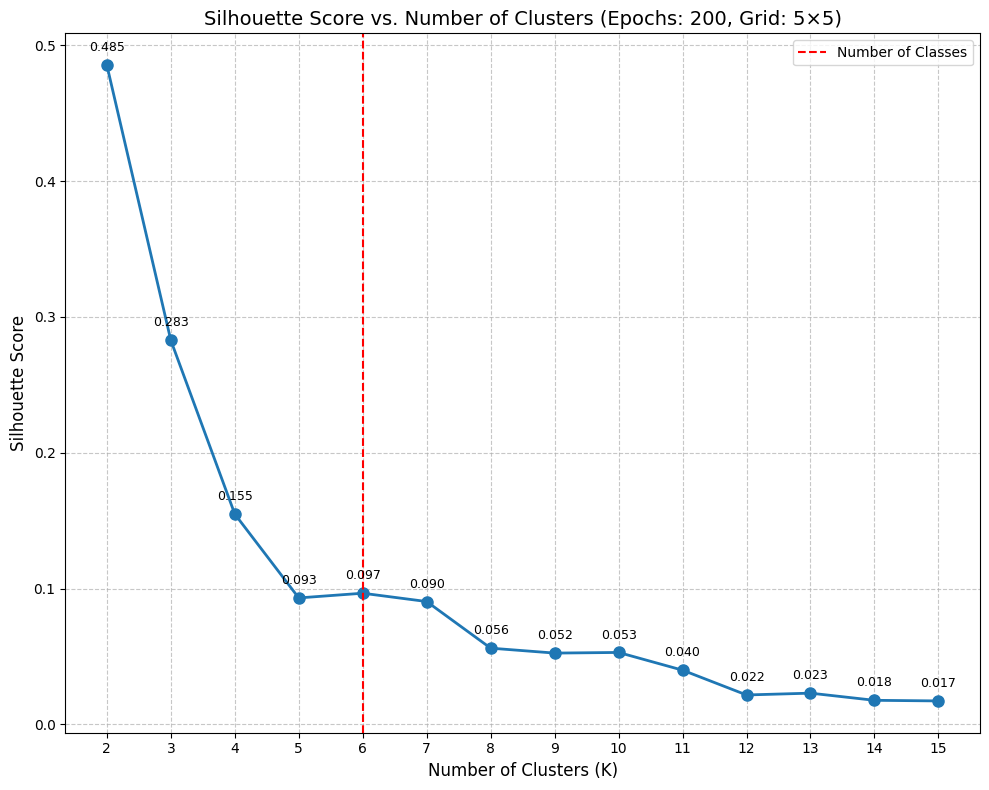

In [61]:
classes = har_labels
data = har_data[:1000, :]

unique_classes = len(np.unique(classes))

grid_size = (5, 5)
epoch_size = 200
plt.figure(figsize=(10, 8))
plt.title("Cluster Number Analysis", fontsize=16)
cluster_sizes, silhouette_scores = analyze_som_clustering(
    data,
    max_clusters=15,
    grid_size=grid_size,
    epochs=epoch_size
)

plt.plot(cluster_sizes, silhouette_scores, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title(f'Silhouette Score vs. Number of Clusters (Epochs: {epoch_size}, Grid: {grid_size[0]}×{grid_size[1]})', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(cluster_sizes)

for i, score in enumerate(silhouette_scores):
    if not np.isnan(score):
        plt.annotate(f'{score:.3f}',
                (cluster_sizes[i], score),
                textcoords="offset points",
                xytext=(0, 10),
                ha='center',
                fontsize=9)
plt.axvline(x=unique_classes, color='r', linestyle='--', label='Number of Classes')
plt.legend()

valid_scores = [(k, score) for k, score in zip(cluster_sizes, silhouette_scores) if not np.isnan(score)]
if valid_scores:
    best_k, best_score = max(valid_scores, key=lambda x: x[1])
    print(f"Optimal number of clusters: {best_k} with silhouette score: {best_score:.3f}")
else:
    print("No valid silhouette scores found")

plt.tight_layout()
plt.show()

Training SOM with fixed grid size 5x5...


Trening sieci: 100%|██████████| 300/300 [03:05<00:00,  1.62epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.480
Evaluating with 3 clusters...
  Silhouette score: 0.300
Evaluating with 4 clusters...
  Silhouette score: 0.159
Evaluating with 5 clusters...
  Silhouette score: 0.118
Evaluating with 6 clusters...
  Silhouette score: 0.104
Evaluating with 7 clusters...
  Silhouette score: 0.100
Evaluating with 8 clusters...
  Silhouette score: 0.079
Evaluating with 9 clusters...
  Silhouette score: 0.032
Evaluating with 10 clusters...
  Silhouette score: 0.049
Evaluating with 11 clusters...
  Silhouette score: 0.040
Evaluating with 12 clusters...
  Silhouette score: 0.040
Evaluating with 13 clusters...
  Silhouette score: 0.044
Evaluating with 14 clusters...
  Silhouette score: 0.044
Evaluating with 15 clusters...
  Silhouette score: 0.038
Optimal number of clusters: 2 with silhouette score: 0.480


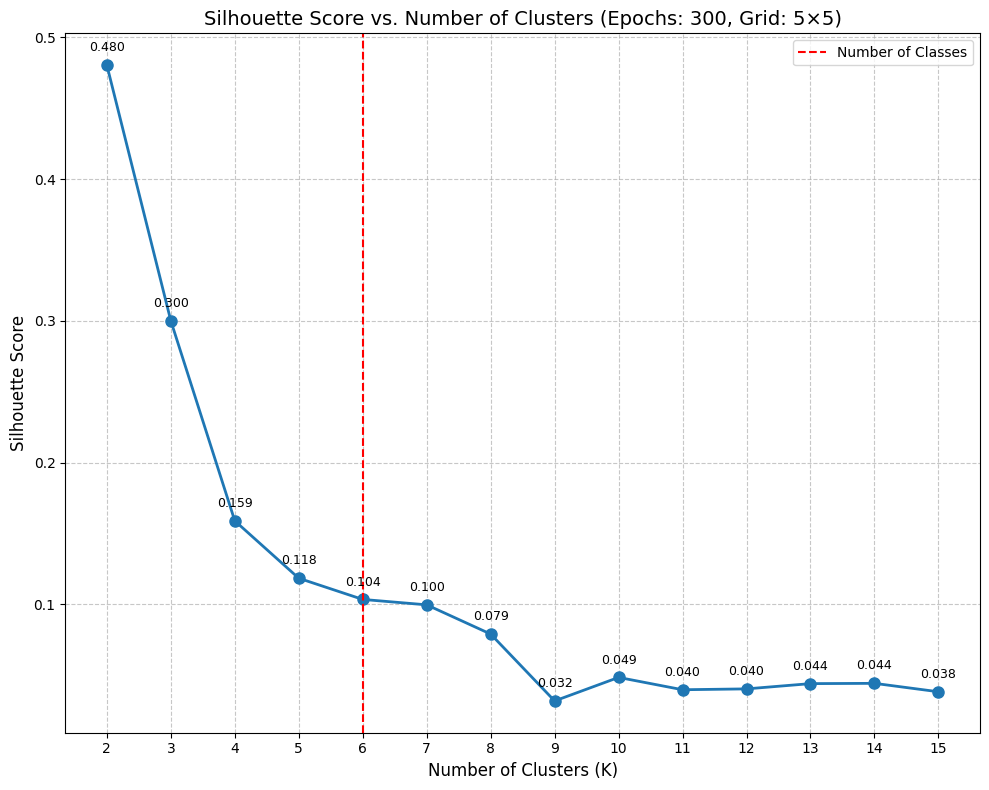

In [63]:
classes = har_labels
data = har_data

unique_classes = len(np.unique(classes))

grid_size = (5, 5)
epoch_size = 300
plt.figure(figsize=(10, 8))
plt.title("Cluster Number Analysis", fontsize=16)
cluster_sizes, silhouette_scores = analyze_som_clustering(
    data,
    max_clusters=15,
    grid_size=grid_size,
    epochs=epoch_size
)

plt.plot(cluster_sizes, silhouette_scores, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title(f'Silhouette Score vs. Number of Clusters (Epochs: {epoch_size}, Grid: {grid_size[0]}×{grid_size[1]})', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(cluster_sizes)

for i, score in enumerate(silhouette_scores):
    if not np.isnan(score):
        plt.annotate(f'{score:.3f}',
                (cluster_sizes[i], score),
                textcoords="offset points",
                xytext=(0, 10),
                ha='center',
                fontsize=9)
plt.axvline(x=unique_classes, color='r', linestyle='--', label='Number of Classes')
plt.legend()

valid_scores = [(k, score) for k, score in zip(cluster_sizes, silhouette_scores) if not np.isnan(score)]
if valid_scores:
    best_k, best_score = max(valid_scores, key=lambda x: x[1])
    print(f"Optimal number of clusters: {best_k} with silhouette score: {best_score:.3f}")
else:
    print("No valid silhouette scores found")

plt.tight_layout()
plt.show()

# Testing

In [ ]:


def analyze_kohonen_results(som, data, labels, title):
    """Analizuj wyniki mapowania na sieci Kohonena"""
    analysis = som.analyze_clustering(data, labels)
    
    print(f"\n=== Analiza: {title} ===")
    print(f"Liczba znalezionych klastrów: {analysis['num_clusters']}")
    print(f"Liczba rzeczywistych klas: {analysis['num_classes']}")
    print(f"Czy klastry odpowiadają klasom: {analysis['clusters_match_classes']}")
    print(f"Procent neuronów z mieszanymi klasami: {analysis['mixed_classes_percentage']:.2%}")
    print(f"Neurony z danymi: {analysis['neurons_with_data']}")
    
    # Analiza czystości neuronów
    if analysis['neuron_stats']:
        purities = [stat['purity'] for stat in analysis['neuron_stats'].values()]
        print(f"Średnia czystość neuronów: {np.mean(purities):.3f}")
        print(f"Maksymalna czystość neuronu: {np.max(purities):.3f}")
        print(f"Minimalna czystość neuronu: {np.min(purities):.3f}")
    
    return analysis

def run_mnist_experiment():
    """Eksperyment z danymi MNIST"""
    print("=== Eksperyment MNIST ===")
    
    # Załaduj dane
    data, labels = load_mnist_data()
    
    # Test z różnymi konfiguracjami
    configs = [
        ('rectangular', 'gaussian'),
        ('rectangular', 'mexican_hat'),
        ('hexagonal', 'gaussian'),
        ('hexagonal', 'mexican_hat')
    ]
    
    results = {}
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, (topology, func) in enumerate(configs):
        title = f"MNIST - {topology} - {func}"
        som = KohonenNetwork(input_dim=data.shape[1], 
                             grid_size=(15, 15),
                             topology=topology, 
                             neighborhood_function=func,
                             neighborhood_width=3.0)
        
        som.train(data[:5000], epochs=100)  # Użyj pierwszych 5000 próbek dla szybkości
        som.visualize_map(data[:5000], labels[:5000], title, axes[i])
        
        results[title] = analyze_kohonen_results(som, data[:5000], labels[:5000], title)
    
    plt.tight_layout()
    plt.show()
    
    return results

def run_har_experiment():
    """Eksperyment z danymi Human Activity Recognition"""
    print("\n=== Eksperyment Human Activity Recognition ===")
    
    # Załaduj dane
    data, labels = load_har_data()
    
    if data is None:
        print("Nie udało się załadować danych HAR")
        return None
    
    # Test z różnymi konfiguracjami
    configs = [
        ('rectangular', 'gaussian'),
        ('rectangular', 'mexican_hat'),
        ('hexagonal', 'gaussian'),
        ('hexagonal', 'mexican_hat')
    ]
    
    results = {}
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, (topology, func) in enumerate(configs):
        title = f"HAR - {topology} - {func}"
        som = KohonenNetwork(input_dim=data.shape[1], 
                             grid_size=(12, 12),
                             topology=topology, 
                             neighborhood_function=func,
                             neighborhood_width=2.0)
        
        som.train(data, epochs=150)
        som.visualize_map(data, labels, title, axes[i])
        
        results[title] = analyze_kohonen_results(som, data, labels, title)
    
    plt.tight_layout()
    plt.show()
    
    return results


In [ ]:
run_mnist_experiment()

In [ ]:
def run_mnist_experiment():
    """Eksperyment z danymi MNIST"""
    print("=== Eksperyment MNIST ===")
    
    # Załaduj dane
    data, labels = load_mnist_data()
    
    # Test z różnymi konfiguracjami
    configs = [
        ('rectangular', 'gaussian'),
        ('rectangular', 'mexican_hat'),
        ('hexagonal', 'gaussian'),
        ('hexagonal', 'mexican_hat')
    ]
    
    results = {}
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, (topology, func) in enumerate(configs):
        title = f"MNIST - {topology} - {func}"
        som = KohonenNetwork(input_dim=data.shape[1], 
                             grid_size=(15, 15),
                             topology=topology, 
                             neighborhood_function=func,
                             neighborhood_width=3.0)
        
        som.train(data[:5000], epochs=100)  # Użyj pierwszych 5000 próbek dla szybkości
        som.visualize_map(data[:5000], labels[:5000], title, axes[i])
        
        results[title] = analyze_kohonen_results(som, data[:5000], labels[:5000], title)
    
    plt.tight_layout()
    plt.show()
    
    return results

# 1 at a time

In [ ]:
data, labels = load_mnist_data()

In [ ]:
data.shape, labels.shape

In [ ]:
data

In [ ]:
som = KohonenNetwork(input_dim=data.shape[1], grid_size=(10, 10), topology='rectangular', neighborhood_function='gaussian')
som.train(data[:5000], epochs=100)

In [ ]:
som.visualize_map(data[:5000], labels[:5000], "MNIST - Rectangular - Gaussian")

## Efect of neighborhood width on classification

In [ ]:
neighborhood_widths = [0.5, 1.0, 2.0, 3.0]
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
networks = []
for i, width in enumerate(neighborhood_widths):

    som = KohonenNetwork(input_dim=data.shape[1], grid_size=(10, 10), topology='rectangular', neighborhood_function='gaussian')
    som.train(data[:5000], epochs=100)
    som.visualize_map(data[:5000], labels[:5000], f"MNIST - Rectangular - Gaussian (width={width})", axes[i//2, i%2])
    axes[i//2, i%2].set_title(f"width={width}")
    networks.append(som)

In [ ]:
som.visualize_map(data[:5000], labels[:5000], "MNIST - Rectangular - Gaussian")

In [ ]:
som.analyze_clustering(data[:5000], labels[:5000])

## HEX

In [ ]:
som = KohonenNetwork(input_dim=data.shape[1], grid_size=(10, 10), topology='hexagonal', neighborhood_function='gaussian')
som.train(data[:5000], epochs=100)

In [ ]:
x_data, y_train = load_mnist_data()
    
# Utwórz i trenuj sieć Kohonena
# Upewnij się, że dane są w odpowiednim formacie
som = KohonenNetwork(input_dim=x_data.shape[1], grid_size=(10, 10), 
                        topology='hexagonal', neighborhood_function='gaussian')

# Ogranicz liczbę próbek do treningu, jeśli to konieczne
num_samples = min(5000, x_data.shape[0])
training_data = x_data[:num_samples].copy()  # Użyj .copy() aby uniknąć problemów z widokiem danych

# Trening sieci
som.train(training_data, epochs=100)

# Wizualizacja wyników
plt.figure(figsize=(12, 10))
som.visualize_map(x_data, y_train, "Sieć Kohonena - MNIST")
plt.show()

# Analiza klastrowania
analysis = som.analyze_clustering(x_data, y_train)
print(f"Liczba klastrów: {analysis['num_clusters']}")
print(f"Liczba klas: {analysis['num_classes']}")
print(f"Procent neuronów z mieszanymi klasami: {analysis['mixed_classes_percentage']:.2f}")
